In [12]:
import torch
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
plt.rcParams['figure.dpi'] = 150
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [2]:
from scipy.stats import pearsonr

In [16]:
import ot
import sklearn.datasets as skdata

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [4]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [5]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [6]:
print(np.__version__)

1.20.2


In [7]:
ndim = 2

In [8]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

#N_FLOWS = 6 
#Z_DIM = 8

N_FLOWS = 10
Z_DIM = 8

n_steps = 0

In [28]:
class Case:
    def __init__(self, casestring, meanbase, meantest, sigmabase, sigmatest):

        self.casestring = casestring
        self.meanbase = meanbase
        self.meantest = meantest
        self.sigmabase = sigmabase
        self.sigmatest = sigmatest
        self.distbase = MultivariateNormal(meanbase,sigmabase)
        self.disttest = MultivariateNormal(meantest,sigmatest)
        self.testsample = self.disttest.rsample([10000])
        N_FLOWS = 10
        Z_DIM = 8
        self.model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.N_EPOCHS = 30
        self.PRINT_INTERVAL = 2000
        self.n_steps = 0
        self.ae_def = {
            "type":"moderate_case",
            "trainon":"Gaussian",
            "features":"RandomSample",
            "architecture":"MAF",
            "selection":"noselection",
            "trainloss":"MSELoss",
            "beta":"beta1",
            "zdimnflow":"z8f10",
        }


    def train(self, train_iterator):
        train_loss = []
        self.model.train()

        for batch_idx, x in enumerate(train_iterator):
            start_time = time.time()
            x = x.float().cuda()
            x_tilde, kl_div = self.model(x)

            mseloss = nn.MSELoss(size_average=False)
            #huberloss = nn.SmoothL1Loss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)

            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + kl_div

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss.append([loss_recons.item(), kl_div.item()])

            if (batch_idx + 1) % self.PRINT_INTERVAL == 0:
                print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                    batch_idx * len(x), 50000,
                    self.PRINT_INTERVAL * batch_idx / 50000,
                    np.asarray(train_loss)[-self.PRINT_INTERVAL:].mean(0),
                    1000 * (time.time() - start_time)
                ))

            self.n_steps += 1

    def evaluate(self, test_iterator, split='valid'):
        start_time = time.time()
        val_loss = []
        self.model.eval()

        with torch.no_grad():
            for batch_idx, x in enumerate(test_iterator):

                x = x.float().cuda()

                x_tilde, kl_div = self.model(x)
                mseloss = nn.MSELoss(size_average=False)
                #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
                huberloss = nn.SmoothL1Loss(size_average=False)


                #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
                loss_recons = mseloss(x_tilde,x ) / x.size(0)
                #loss_recons = huberloss(x_tilde,x ) / x.size(0)
                loss = loss_recons + kl_div

                val_loss.append(loss.item())
                #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
                #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
                #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

        print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
            split,
            np.asarray(val_loss).mean(0),
            time.time() - start_time
        ))
        return np.asarray(val_loss).mean(0)


    def train_model(self):
        train_data = self.distbase.rsample([100000])
        test_data = self.distbase.rsample([100000])
        train_data = torch.tensor(train_data)
        test_data = torch.tensor(test_data)
        bs = 800
        train_iterator = utils.DataLoader(train_data, batch_size=bs, shuffle=True)
        test_iterator = utils.DataLoader(test_data, batch_size=bs)

        N_EPOCHS = 10
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, 1000):
            print("Epoch {}:".format(epoch))
            self.train(train_iterator)
            cur_loss = self.evaluate(test_iterator)

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                torch.save(self.model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{self.ae_def['type']}_{self.ae_def['trainon']}_{self.ae_def['features']}_{self.ae_def['architecture']}_{self.ae_def['selection']}_{self.ae_def['trainloss']}_{self.ae_def['beta']}_{self.ae_def['zdimnflow']}.h5")

            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 10:
                    print("Patience Limit Reached")
                    break

    def load_model(self):
        self.model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{self.ae_def['type']}_{self.ae_def['trainon']}_{self.ae_def['features']}_{self.ae_def['architecture']}_{self.ae_def['selection']}_{self.ae_def['trainloss']}_{self.ae_def['beta']}_{self.ae_def['zdimnflow']}.h5"))

    def get_NLL_withinput(self, input_data):
        return -self.distbase.log_prob(input_data).data.cpu().numpy()


    def get_Loss_withinput(self, input_data):
        return torch.mean((self.model(input_data.float().cuda())[0]- input_data.float().cuda())**2,dim=1).data.cpu().numpy()

    def get_Wasserstein_withinput(self, input_data):

        wass_list = np.array([])
        a = ot.unif(2)
        b = ot.unif(2)

        for row in input_data:
            #xs = np.array([0.,0.])
            #xt = np.array([0.,0.])
            #xs[0] = 0.
            #xs[1] = 0.
            #xt[0] = row[0]
            #xt[1] = row[1]
            #M = ot.dist(xs, xt, metric='euclidean')
            M = np.array([[abs(row[0]),abs(row[1])],[abs(row[0]),abs(row[1])]])
            M /= M.max()
            wass_list = np.append(wass_list, ot.emd2(a,b, M))

        return wass_list




    def get_NLL(self):
        return -self.distbase.log_prob(self.testsample).data.cpu().numpy()


    def get_Loss(self):
        return torch.mean((self.model(self.testsample.float().cuda())[0]- self.testsample.float().cuda())**2,dim=1).data.cpu().numpy()

    def get_Wasserstein(self):

        wass_list = np.array([])
        a = ot.unif(2)
        b = ot.unif(2)

        for row in self.testsample:
            #xs = np.array([0.,0.])
            #xt = np.array([0.,0.])
            #xs[0] = 0.
            #xs[1] = 0.
            #xt[0] = row[0]
            #xt[1] = row[1]
            #M = ot.dist(xs, xt, metric='euclidean')
            M = np.array([[abs(row[0]),abs(row[1])],[abs(row[0]),abs(row[1])]])
            M /= M.max()
            wass_list = np.append(wass_list, ot.emd2(a,b, M))

        return wass_list


    def get_rawdistance(self):
        return torch.sqrt(self.testsample[:,0]**2 + self.testsample[:,1]**2).data().numpy()

    def randomly_regenerate(self):
        mean_a = dista_mean = torch.zeros(2)
        mean_b = torch.zeros(ndim).normal_(0., 3.)
        sigma_a = skdata.make_spd_matrix(2)
        sigma_b = skdata.make_spd_matrix(2)
        sigma_a = torch.FloatTensor(sigma_a)
        sigma_b = torch.FloatTensor(sigma_b)
        self.distbase = MultivariateNormal(mean_a,sigma_a)
        self.disttest = MultivariateNormal(mean_b,sigma_b)

    def plot_roc(self, rl_loss, rh_loss, rl_wass, rh_wass):
        samplebase = self.distbase.rsample([1000])
        sampletest = self.disttest.rsample([1000])

        data = torch.vstack((samplebase, sampletest))
        label = np.concatenate([np.zeros(1000),np.ones(1000)])

        wass_list = self.get_Wasserstein_withinput(data)
        loss_list = self.get_Loss_withinput(data)

        loss_tpr, loss_fpr = self.get_tpr_fpr(loss_list[label==1], loss_list[label==0],rl_loss, rh_loss)
        wass_tpr, wass_fpr = self.get_tpr_fpr(wass_list[label==1], wass_list[label==0],rl_wass, rh_wass)


        plt.plot(loss_fpr, loss_tpr, label=f'{self.casestring} MSE')
        plt.plot(wass_fpr, wass_tpr, label=f'{self.casestring} Wasserstein')
        plt.legend(loc=4,fontsize=10)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.savefig(f'./figures/{self.casestring}_roc.png')
        plt.show()

    def get_tpr_fpr(self, sigloss,bkgloss,range_low, range_high, aetype='bkg'):
        bins = np.linspace(range_low,range_high,1001)
        tpr = []
        fpr = []
        for cut in bins:
            if aetype == 'sig':
                tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
                fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
            if aetype == 'bkg':
                tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
                fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
        return tpr,fpr

    def make_scatterplot_anomaly(self, N, maxN, type):
        alpha_val = 0.5
        if maxN > 500:
            alpha_val = 0.1
        samplebase = self.distbase.rsample([N])
        sampletest = self.disttest.rsample([N])

        data = torch.vstack((samplebase, sampletest))

        label = np.concatenate([np.zeros(N),np.ones(N)])


        plt.scatter(data[:,0], data[:,1], color='dimgrey', alpha=0.1, label=f'dataset size {2*N}')

        nll_list = self.get_NLL_withinput(data)
        wass_list = self.get_Wasserstein_withinput(data)
        loss_list = self.get_Loss_withinput(data)

        maxwass_ind = np.argpartition(wass_list, -maxN)[-maxN:]
        maxloss_ind = np.argpartition(loss_list, -maxN)[-maxN:]
        maxnll_ind  = np.argpartition(nll_list, -maxN)[-maxN:]

        if type == 'Loss':
            label = label[maxloss_ind]
            data = data[maxloss_ind]
            correct = data[label==1]
            wrong = data[label==0]


            #plt.scatter(data[maxloss_ind,0],data[maxloss_ind,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss')
            plt.scatter(correct[:,0],correct[:,1],color='m',alpha=alpha_val, marker='o', label=f'{maxN} max MSE loss, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss, wrong')


        elif type == 'Wasserstein':
            label = label[maxwass_ind]
            data = data[maxwass_ind]
            correct = data[label==1]
            wrong = data[label==0]
            plt.scatter(correct[:,0],correct[:,1],color='lime',alpha=alpha_val, marker='o', label=f'{maxN} max wasserstein, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='lime',alpha=alpha_val, marker='x', label=f'{maxN} max wasserstein, wrong')

        elif type == 'NLL':
            label = label[maxnll_ind]
            data = data[maxnll_ind]
            correct = data[label==1]
            wrong = data[label==0]
            plt.scatter(correct[:,0],correct[:,1],color='orange',alpha=alpha_val, marker='o', label=f'{maxN} max NLL, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='orange',alpha=alpha_val, marker='x', label=f'{maxN} max NLL, wrong')

        else:
            print("null")



        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot_anomaly_{type}.png')
        plt.show()


    def make_scatterplot_with_highlights(self,maxN):
        samplebase_plot = self.distbase.rsample([130])
        #sampletest_plot = self.disttest.rsample([130])
        plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
        if maxN <=500:
            plt.scatter(self.testsample[:2000,0],self.testsample[:2000,1],color='b',alpha= 0.05, label='test(Anomaly)')
        wass_list = self.get_Wasserstein()
        loss_list = self.get_Loss()
        nll_list = self.get_NLL()
        maxwass_ind = np.argpartition(wass_list, -maxN)[-maxN:]
        maxloss_ind = np.argpartition(loss_list, -maxN)[-maxN:]
        maxnll_ind  = np.argpartition(nll_list, -maxN)[-maxN:]
        alpha_val =0.5
        if maxN > 500:
            alpha_val = 0.05
        plt.scatter(self.testsample[maxwass_ind,0],self.testsample[maxwass_ind,1],color='lime',alpha=alpha_val, marker='+', label=f'{maxN} max wasserstein')
        plt.scatter(self.testsample[maxloss_ind,0],self.testsample[maxloss_ind,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss')
        plt.scatter(self.testsample[maxnll_ind,0],self.testsample[maxnll_ind,1],color='orange',alpha=alpha_val, marker='v', label=f'{maxN} max NLL')


        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot_highlights.png')
        plt.show()


    def make_scatterplot(self):
        samplebase_plot = self.distbase.rsample([130])
        sampletest_plot = self.disttest.rsample([130])
        plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
        plt.scatter(sampletest_plot[:,0],sampletest_plot[:,1],color='b',alpha= 0.5, label='test(Anomaly)')
        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot.png')
        plt.show()


    def make_hexbin_plot_rawdist_MSE(self,xrange,yrange,textlocx,textlocy):
        rawdist = self.get_rawdist()
        mse =  self.get_Loss()
        pearsonr_msenll = pearsonr(mse, rawdist)
        plotrange = np.where((mse<xrange) & (nll<yrange))[0]
        plt.hexbin(mse[plotrange],nll[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('NLL')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msenll[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_MSE.png')
        plt.show()

    def make_hexbinplot_NLL_MSE(self,xrange,yrange,textlocx,textlocy):
        nll = self.get_NLL()
        mse =  self.get_Loss()
        pearsonr_msenll = pearsonr(mse, nll)
        plotrange = np.where((mse<xrange) & (nll<yrange))[0]
        plt.hexbin(mse[plotrange],nll[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('NLL')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msenll[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_MSE.png')
        plt.show()
#plt.text(1,2.1,f'evaluated on QCD',color='white')
##plt.text(1,2.1,f'evaluated on QCD',color='white')



    def make_hexbinplot_NLL_Wasserstein(self,xrange,yrange,textlocx,textlocy):
        nll = self.get_NLL()
        wasserstein = self.get_Wasserstein()
        pearsonr_nllwasserstein = pearsonr(nll, wasserstein)
        plotrange = np.where((nll<xrange) & (wasserstein<yrange) & (wasserstein>0))[0]
        plt.hexbin(nll[plotrange],wasserstein[plotrange],gridsize=40)
        plt.xlabel('NLL')
        plt.ylabel('1D Wasserstein')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_nllwasserstein[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_Wasserstein.png')
        plt.show()

    def make_hexbinplot_MSE_Wasserstein(self,xrange,yrange,textlocx,textlocy):
        mse =  self.get_Loss()
        wasserstein = self.get_Wasserstein()
        pearsonr_msewasserstein = pearsonr(mse, wasserstein)
        plotrange = np.where((mse<xrange) & (wasserstein<yrange) & (wasserstein>0))[0]
        plt.hexbin(mse[plotrange],wasserstein[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('1D Wasserstein')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msewasserstein[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_MSE_Wasserstein.png')
        plt.show()

    #def wasserstein_distance_between_pdfs(self):

    #def allplots(self):
        #nll = self.get_NLL()
        #mse =  self.get_Loss()
        #wasserstein = self.get_Wasserstein()


In [10]:
ndim = 2

In [19]:
class Case:
    def __init__(self, casestring, meanbase, meantest, sigmabase, sigmatest):

        self.casestring = casestring
        self.meanbase = meanbase
        self.meantest = meantest
        self.sigmabase = sigmabase
        self.sigmatest = sigmatest
        self.distbase = MultivariateNormal(meanbase,sigmabase)
        self.disttest = MultivariateNormal(meantest,sigmatest)
        self.testsample = self.disttest.rsample([10000])
        N_FLOWS = 10
        Z_DIM = 8
        self.model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.N_EPOCHS = 30
        self.PRINT_INTERVAL = 2000
        self.n_steps = 0
        self.ae_def = {
            "type":"moderate_case",
            "trainon":"Gaussian",
            "features":"RandomSample",
            "architecture":"MAF",
            "selection":"noselection",
            "trainloss":"MSELoss",
            "beta":"beta1",
            "zdimnflow":"z8f10",
        }


    def train(self, train_iterator):
        train_loss = []
        self.model.train()

        for batch_idx, x in enumerate(train_iterator):
            start_time = time.time()
            x = x.float().cuda()
            x_tilde, kl_div = self.model(x)

            mseloss = nn.MSELoss(size_average=False)
            #huberloss = nn.SmoothL1Loss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)

            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + kl_div

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss.append([loss_recons.item(), kl_div.item()])

            if (batch_idx + 1) % self.PRINT_INTERVAL == 0:
                print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                    batch_idx * len(x), 50000,
                    self.PRINT_INTERVAL * batch_idx / 50000,
                    np.asarray(train_loss)[-self.PRINT_INTERVAL:].mean(0),
                    1000 * (time.time() - start_time)
                ))

            self.n_steps += 1

    def evaluate(self, test_iterator, split='valid'):
        start_time = time.time()
        val_loss = []
        self.model.eval()

        with torch.no_grad():
            for batch_idx, x in enumerate(test_iterator):

                x = x.float().cuda()

                x_tilde, kl_div = self.model(x)
                mseloss = nn.MSELoss(size_average=False)
                #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
                huberloss = nn.SmoothL1Loss(size_average=False)


                #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
                loss_recons = mseloss(x_tilde,x ) / x.size(0)
                #loss_recons = huberloss(x_tilde,x ) / x.size(0)
                loss = loss_recons + kl_div

                val_loss.append(loss.item())
                #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
                #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
                #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

        print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
            split,
            np.asarray(val_loss).mean(0),
            time.time() - start_time
        ))
        return np.asarray(val_loss).mean(0)


    def train_model(self):
        train_data = self.distbase.rsample([100000])
        test_data = self.distbase.rsample([100000])
        train_data = torch.tensor(train_data)
        test_data = torch.tensor(test_data)
        bs = 800
        train_iterator = utils.DataLoader(train_data, batch_size=bs, shuffle=True)
        test_iterator = utils.DataLoader(test_data, batch_size=bs)

        N_EPOCHS = 10
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, 1000):
            print("Epoch {}:".format(epoch))
            self.train(train_iterator)
            cur_loss = self.evaluate(test_iterator)

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                torch.save(self.model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{self.ae_def['type']}_{self.ae_def['trainon']}_{self.ae_def['features']}_{self.ae_def['architecture']}_{self.ae_def['selection']}_{self.ae_def['trainloss']}_{self.ae_def['beta']}_{self.ae_def['zdimnflow']}.h5")

            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 10:
                    print("Patience Limit Reached")
                    break

    def load_model(self):
        self.model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{self.ae_def['type']}_{self.ae_def['trainon']}_{self.ae_def['features']}_{self.ae_def['architecture']}_{self.ae_def['selection']}_{self.ae_def['trainloss']}_{self.ae_def['beta']}_{self.ae_def['zdimnflow']}.h5"))

    def get_NLL_withinput(self, input_data):
        return -self.distbase.log_prob(input_data).data.cpu().numpy()


    def get_Loss_withinput(self, input_data):
        return torch.mean((self.model(input_data.float().cuda())[0]- input_data.float().cuda())**2,dim=1).data.cpu().numpy()

    def get_Wasserstein_withinput(self, input_data):

        wass_list = np.array([])
        a = ot.unif(2)
        b = ot.unif(2)

        for row in input_data:
            #xs = np.array([0.,0.])
            #xt = np.array([0.,0.])
            #xs[0] = 0.
            #xs[1] = 0.
            #xt[0] = row[0]
            #xt[1] = row[1]
            #M = ot.dist(xs, xt, metric='euclidean')
            M = np.array([[abs(row[0]),abs(row[1])],[abs(row[0]),abs(row[1])]])
            M /= M.max()
            wass_list = np.append(wass_list, ot.emd2(a,b, M))

        return wass_list




    def get_NLL(self):
        return -self.distbase.log_prob(self.testsample).data.cpu().numpy()


    def get_Loss(self):
        return torch.mean((self.model(self.testsample.float().cuda())[0]- self.testsample.float().cuda())**2,dim=1).data.cpu().numpy()

    def get_Wasserstein(self):

        wass_list = np.array([])
        a = ot.unif(2)
        b = ot.unif(2)

        for row in self.testsample:
            #xs = np.array([0.,0.])
            #xt = np.array([0.,0.])
            #xs[0] = 0.
            #xs[1] = 0.
            #xt[0] = row[0]
            #xt[1] = row[1]
            #M = ot.dist(xs, xt, metric='euclidean')
            M = np.array([[abs(row[0]),abs(row[1])],[abs(row[0]),abs(row[1])]])
            M /= M.max()
            wass_list = np.append(wass_list, ot.emd2(a,b, M))

        return wass_list


    def get_rawdistance(self):
        return torch.sqrt(self.testsample[:,0]**2 + self.testsample[:,1]**2).data().numpy()

    def randomly_regenerate(self):
        mean_a = dista_mean = torch.zeros(2)
        mean_b = torch.zeros(ndim).normal_(0., 10.)
        sigma_a = skdata.make_spd_matrix(2)
        sigma_b = skdata.make_spd_matrix(2)
        sigma_a = torch.FloatTensor(sigma_a)
        sigma_b = torch.FloatTensor(sigma_b)
        self.distbase = MultivariateNormal(mean_a,sigma_a)
        self.disttest = MultivariateNormal(mean_b,sigma_b)

    def plot_roc(self, rl_loss, rh_loss, rl_wass, rh_wass):
        samplebase = self.distbase.rsample([1000])
        sampletest = self.disttest.rsample([1000])

        data = torch.vstack((samplebase, sampletest))
        label = np.concatenate([np.zeros(1000),np.ones(1000)])

        wass_list = self.get_Wasserstein_withinput(data)
        loss_list = self.get_Loss_withinput(data)

        loss_tpr, loss_fpr = self.get_tpr_fpr(loss_list[label==1], loss_list[label==0],rl_loss, rh_loss)
        wass_tpr, wass_fpr = self.get_tpr_fpr(wass_list[label==1], wass_list[label==0],rl_wass, rh_wass)


        plt.plot(loss_fpr, loss_tpr, label=f'{self.casestring} MSE')
        plt.plot(wass_fpr, wass_tpr, label=f'{self.casestring} Wasserstein')
        plt.legend(loc=4,fontsize=10)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.savefig(f'./figures/{self.casestring}_roc.png')
        plt.show()

    def get_tpr_fpr(self, sigloss,bkgloss,range_low, range_high, aetype='bkg'):
        bins = np.linspace(range_low,range_high,1001)
        tpr = []
        fpr = []
        for cut in bins:
            if aetype == 'sig':
                tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
                fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
            if aetype == 'bkg':
                tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
                fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
        return tpr,fpr

    def make_scatterplot_anomaly(self, N, maxN, type):
        alpha_val = 0.5
        if maxN > 500:
            alpha_val = 0.1
        samplebase = self.distbase.rsample([N])
        sampletest = self.disttest.rsample([N])

        data = torch.vstack((samplebase, sampletest))

        label = np.concatenate([np.zeros(N),np.ones(N)])


        plt.scatter(data[:,0], data[:,1], color='dimgrey', alpha=0.1, label=f'dataset size {2*N}')

        nll_list = self.get_NLL_withinput(data)
        wass_list = self.get_Wasserstein_withinput(data)
        loss_list = self.get_Loss_withinput(data)

        maxwass_ind = np.argpartition(wass_list, -maxN)[-maxN:]
        maxloss_ind = np.argpartition(loss_list, -maxN)[-maxN:]
        maxnll_ind  = np.argpartition(nll_list, -maxN)[-maxN:]

        if type == 'Loss':
            label = label[maxloss_ind]
            data = data[maxloss_ind]
            correct = data[label==1]
            wrong = data[label==0]


            #plt.scatter(data[maxloss_ind,0],data[maxloss_ind,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss')
            plt.scatter(correct[:,0],correct[:,1],color='m',alpha=alpha_val, marker='o', label=f'{maxN} max MSE loss, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss, wrong')


        elif type == 'Wasserstein':
            label = label[maxwass_ind]
            data = data[maxwass_ind]
            correct = data[label==1]
            wrong = data[label==0]
            plt.scatter(correct[:,0],correct[:,1],color='lime',alpha=alpha_val, marker='o', label=f'{maxN} max wasserstein, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='lime',alpha=alpha_val, marker='x', label=f'{maxN} max wasserstein, wrong')

        elif type == 'NLL':
            label = label[maxnll_ind]
            data = data[maxnll_ind]
            correct = data[label==1]
            wrong = data[label==0]
            plt.scatter(correct[:,0],correct[:,1],color='orange',alpha=alpha_val, marker='o', label=f'{maxN} max NLL, correct')
            plt.scatter(wrong[:,0],wrong[:,1],color='orange',alpha=alpha_val, marker='x', label=f'{maxN} max NLL, wrong')

        else:
            print("null")



        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot_anomaly_{type}.png')
        plt.show()


    def make_scatterplot_with_highlights(self,maxN):
        samplebase_plot = self.distbase.rsample([130])
        #sampletest_plot = self.disttest.rsample([130])
        plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
        if maxN <=500:
            plt.scatter(self.testsample[:2000,0],self.testsample[:2000,1],color='b',alpha= 0.05, label='test(Anomaly)')
        wass_list = self.get_Wasserstein()
        loss_list = self.get_Loss()
        nll_list = self.get_NLL()
        maxwass_ind = np.argpartition(wass_list, -maxN)[-maxN:]
        maxloss_ind = np.argpartition(loss_list, -maxN)[-maxN:]
        maxnll_ind  = np.argpartition(nll_list, -maxN)[-maxN:]
        alpha_val =0.5
        if maxN > 500:
            alpha_val = 0.05
        plt.scatter(self.testsample[maxwass_ind,0],self.testsample[maxwass_ind,1],color='lime',alpha=alpha_val, marker='+', label=f'{maxN} max wasserstein')
        plt.scatter(self.testsample[maxloss_ind,0],self.testsample[maxloss_ind,1],color='m',alpha=alpha_val, marker='x', label=f'{maxN} max MSE loss')
        plt.scatter(self.testsample[maxnll_ind,0],self.testsample[maxnll_ind,1],color='orange',alpha=alpha_val, marker='v', label=f'{maxN} max NLL')


        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot_highlights.png')
        plt.show()


    def make_scatterplot(self):
        samplebase_plot = self.distbase.rsample([130])
        sampletest_plot = self.disttest.rsample([130])
        plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
        plt.scatter(sampletest_plot[:,0],sampletest_plot[:,1],color='b',alpha= 0.5, label='test(Anomaly)')
        plt.legend()
        plt.savefig(f'./figures/{self.casestring}_scatterplot.png')
        plt.show()


    def make_hexbin_plot_rawdist_MSE(self,xrange,yrange,textlocx,textlocy):
        rawdist = self.get_rawdist()
        mse =  self.get_Loss()
        pearsonr_msenll = pearsonr(mse, rawdist)
        plotrange = np.where((mse<xrange) & (nll<yrange))[0]
        plt.hexbin(mse[plotrange],nll[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('NLL')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msenll[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_MSE.png')
        plt.show()

    def make_hexbinplot_NLL_MSE(self,xrange,yrange,textlocx,textlocy):
        nll = self.get_NLL()
        mse =  self.get_Loss()
        pearsonr_msenll = pearsonr(mse, nll)
        plotrange = np.where((mse<xrange) & (nll<yrange))[0]
        plt.hexbin(mse[plotrange],nll[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('NLL')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msenll[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_MSE.png')
        plt.show()
#plt.text(1,2.1,f'evaluated on QCD',color='white')
##plt.text(1,2.1,f'evaluated on QCD',color='white')



    def make_hexbinplot_NLL_Wasserstein(self,xrange,yrange,textlocx,textlocy):
        nll = self.get_NLL()
        wasserstein = self.get_Wasserstein()
        pearsonr_nllwasserstein = pearsonr(nll, wasserstein)
        plotrange = np.where((nll<xrange) & (wasserstein<yrange) & (wasserstein>0))[0]
        plt.hexbin(nll[plotrange],wasserstein[plotrange],gridsize=40)
        plt.xlabel('NLL')
        plt.ylabel('1D Wasserstein')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_nllwasserstein[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_NLL_Wasserstein.png')
        plt.show()

    def make_hexbinplot_MSE_Wasserstein(self,xrange,yrange,textlocx,textlocy):
        mse =  self.get_Loss()
        wasserstein = self.get_Wasserstein()
        pearsonr_msewasserstein = pearsonr(mse, wasserstein)
        plotrange = np.where((mse<xrange) & (wasserstein<yrange) & (wasserstein>0))[0]
        plt.hexbin(mse[plotrange],wasserstein[plotrange],gridsize=40)
        plt.xlabel('MSE')
        plt.ylabel('1D Wasserstein')
        plt.text(textlocx,textlocy,f'pearson correlation = {pearsonr_msewasserstein[0]:.4f}',color='white')
        plt.savefig(f'./figures/{self.casestring}_hexbinplot_MSE_Wasserstein.png')
        plt.show()

    #def wasserstein_distance_between_pdfs(self):

    #def allplots(self):
        #nll = self.get_NLL()
        #mse =  self.get_Loss()
        #wasserstein = self.get_Wasserstein()


In [60]:
dista_mean = torch.zeros(ndim)
distb_mean = torch.FloatTensor([4.7409, 8.7702])*3

sigma_a = torch.FloatTensor([[2.2828, 1.3097], [1.3097, 2.5028]])
sigma_b = torch.FloatTensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])
far_case = Case("far_case", dista_mean, distb_mean, sigma_a, sigma_b)
far_case.load_model()

In [66]:
min(far_case.get_Loss())

10.423441

In [68]:
max(far_case.get_Loss())

522.8082

In [72]:
min(far_case.get_Wasserstein())

0.64687380194664

In [73]:
max(far_case.get_Wasserstein())

0.9296797811985016

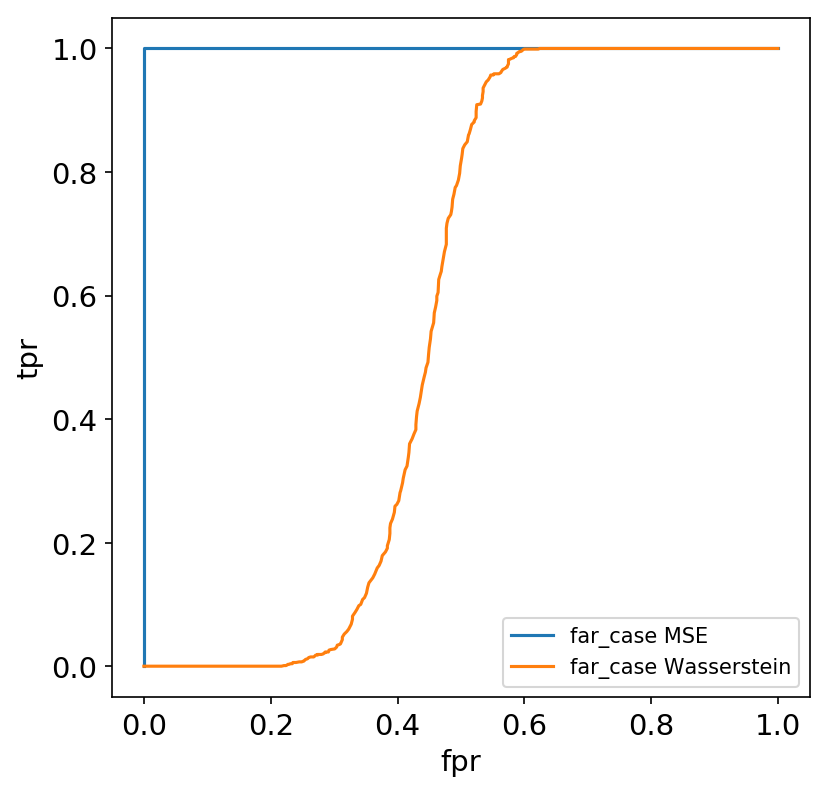

In [74]:
far_case.plot_roc(0,600,0,1)

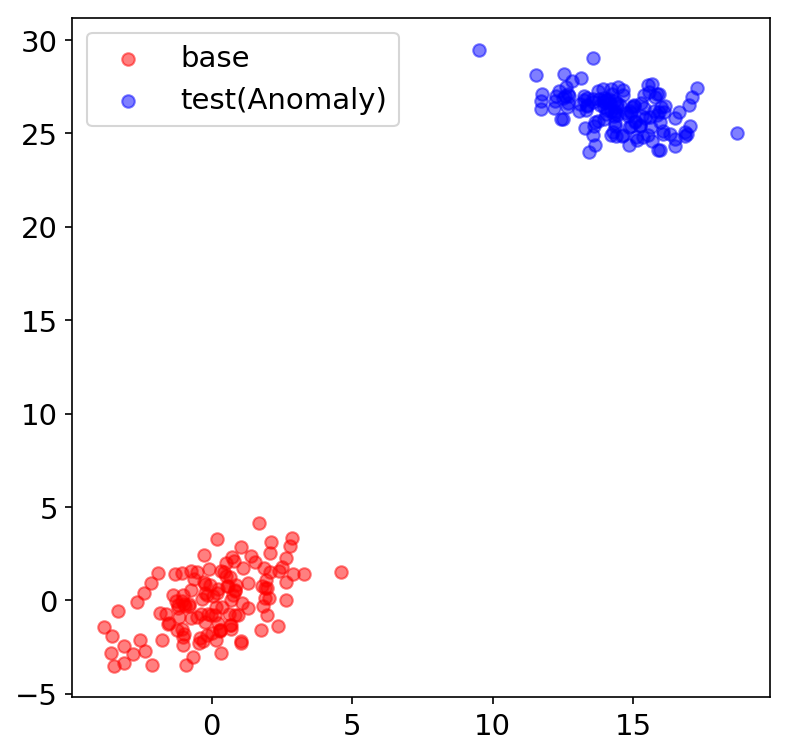

In [61]:
far_case.make_scatterplot()

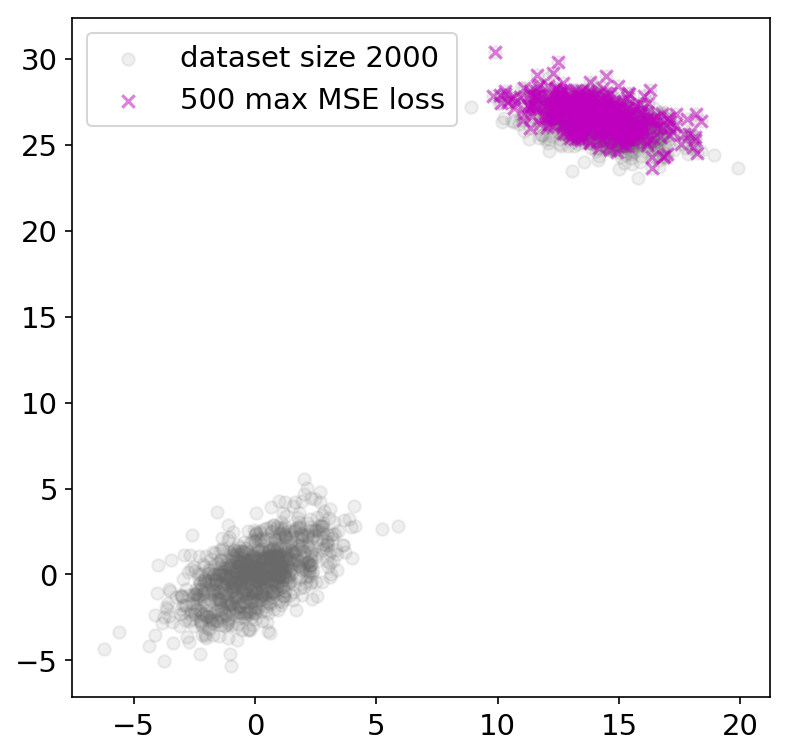

In [34]:
far_case.make_scatterplot_anomaly(1000,500, 'Loss')

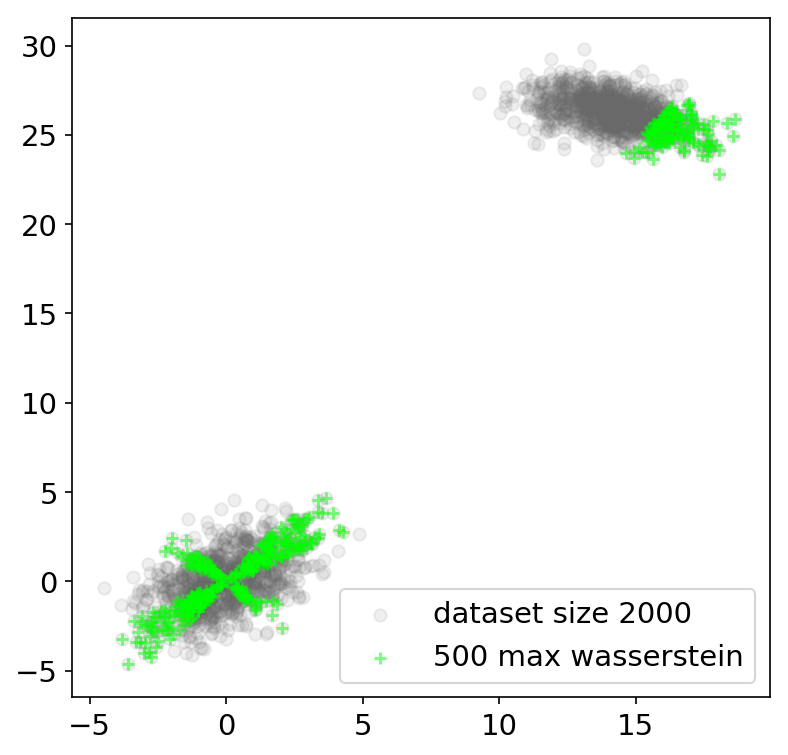

In [35]:
far_case.make_scatterplot_anomaly(1000,500, 'Wasserstein')

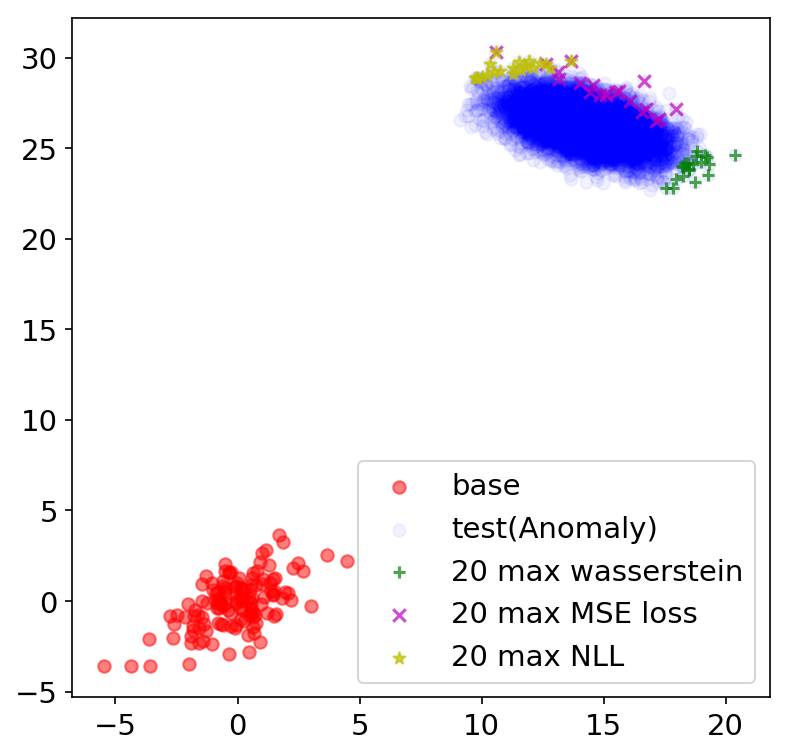

In [46]:
far_case.make_scatterplot_with_highlights()

In [75]:
dista_mean = torch.zeros(ndim)
distb_mean = torch.FloatTensor([4.7409, 8.7702])

sigma_a = torch.FloatTensor([[2.2828, 1.3097], [1.3097, 2.5028]])
sigma_b = torch.FloatTensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])
moderate_case = Case("moderate_case", dista_mean, distb_mean, sigma_a, sigma_b)
moderate_case.load_model()

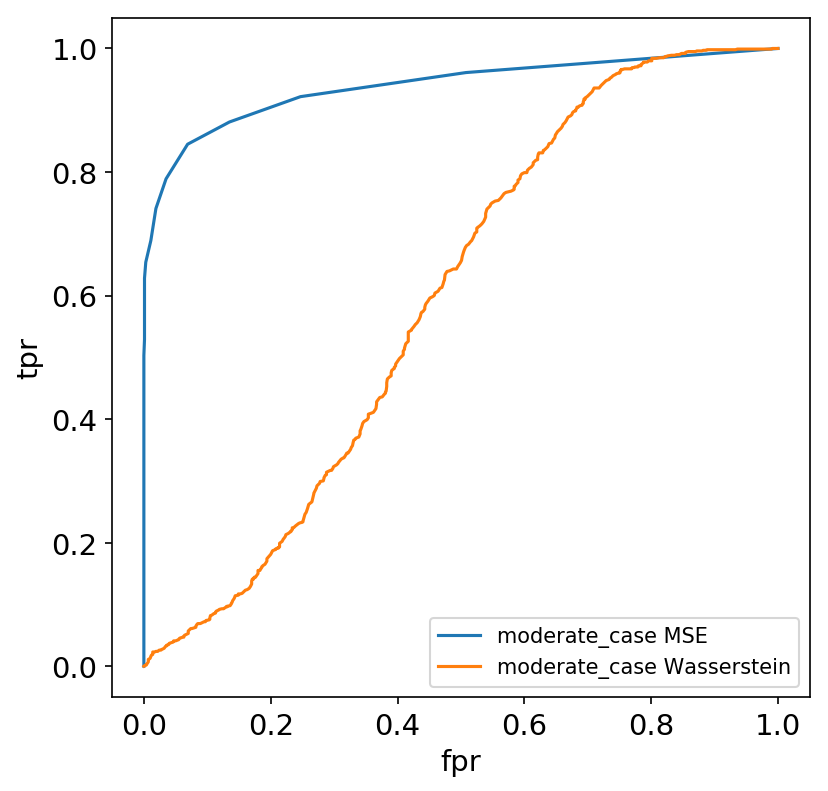

In [77]:
moderate_case.plot_roc(0,600,0,1)

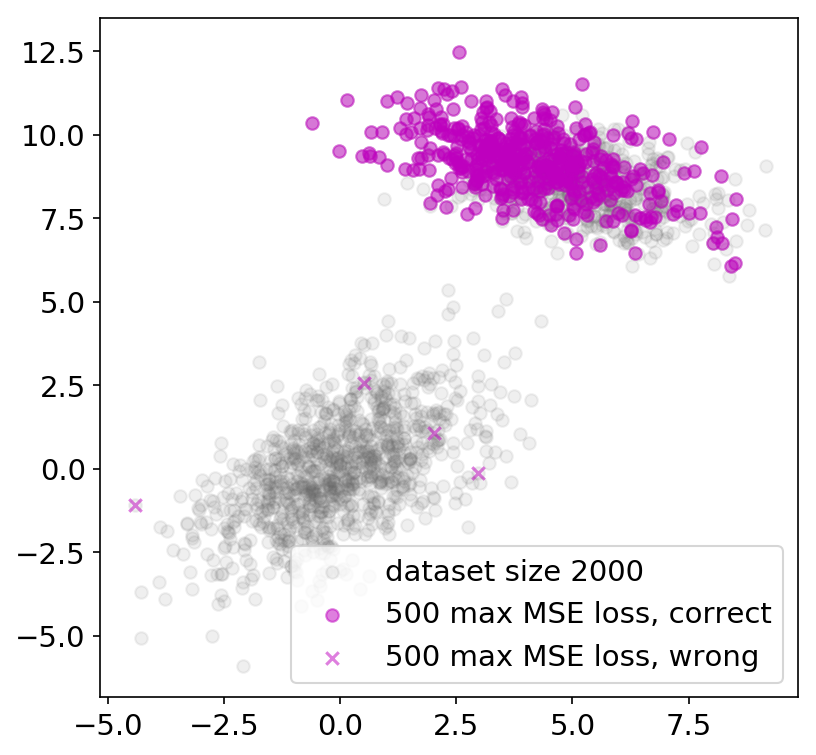

In [33]:
moderate_case.make_scatterplot_anomaly(1000,500, 'Loss')

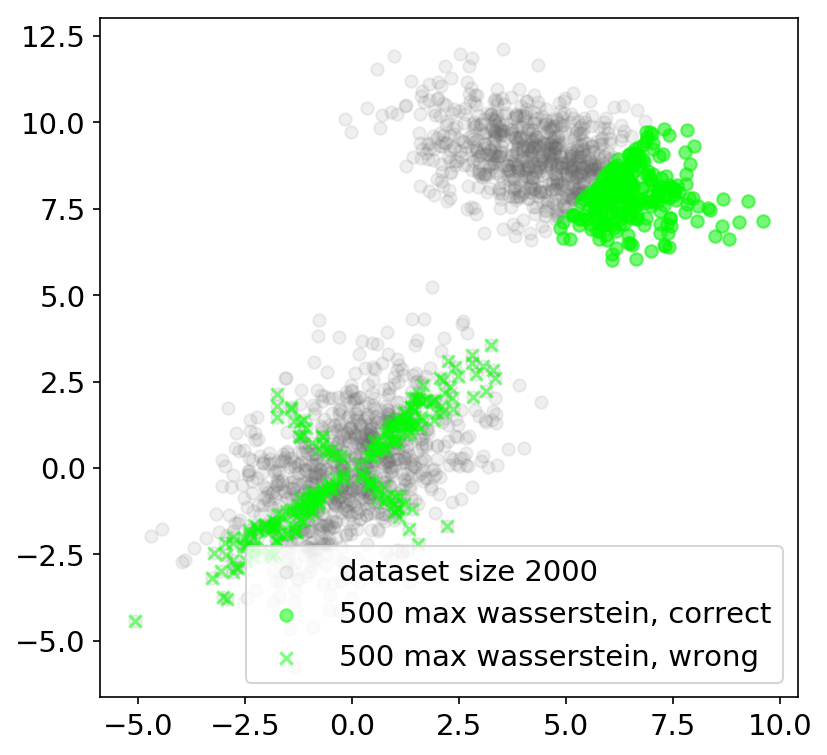

In [34]:
moderate_case.make_scatterplot_anomaly(1000,500, 'Wasserstein')

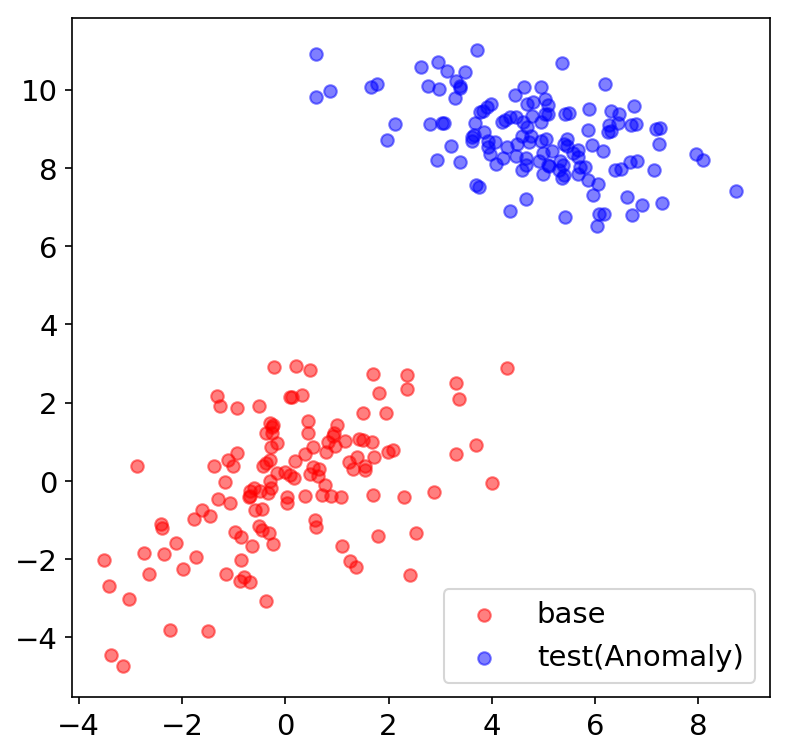

In [64]:
moderate_case.make_scatterplot()

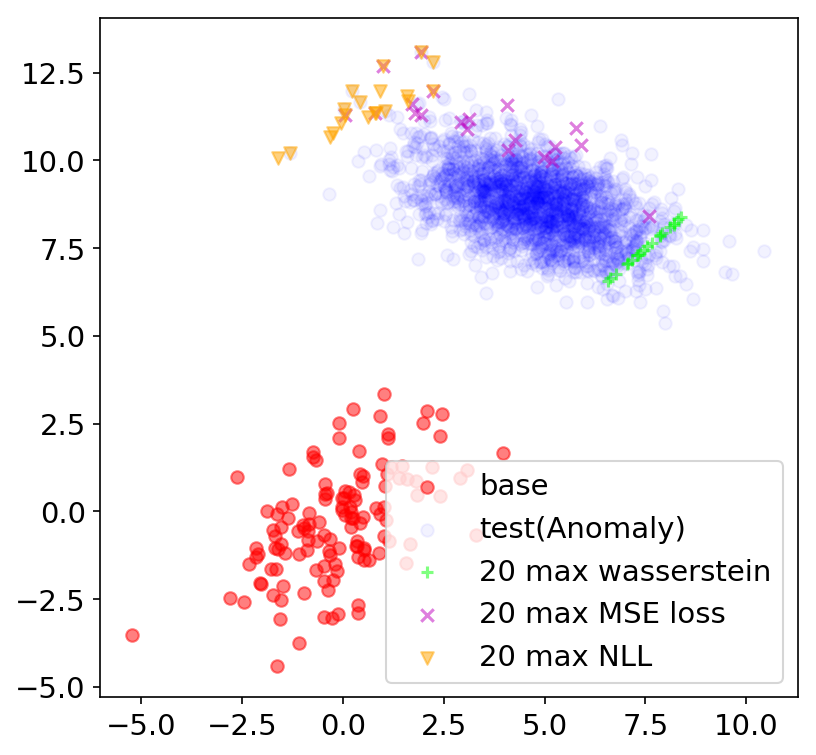

In [34]:
moderate_case.make_scatterplot_with_highlights(20)

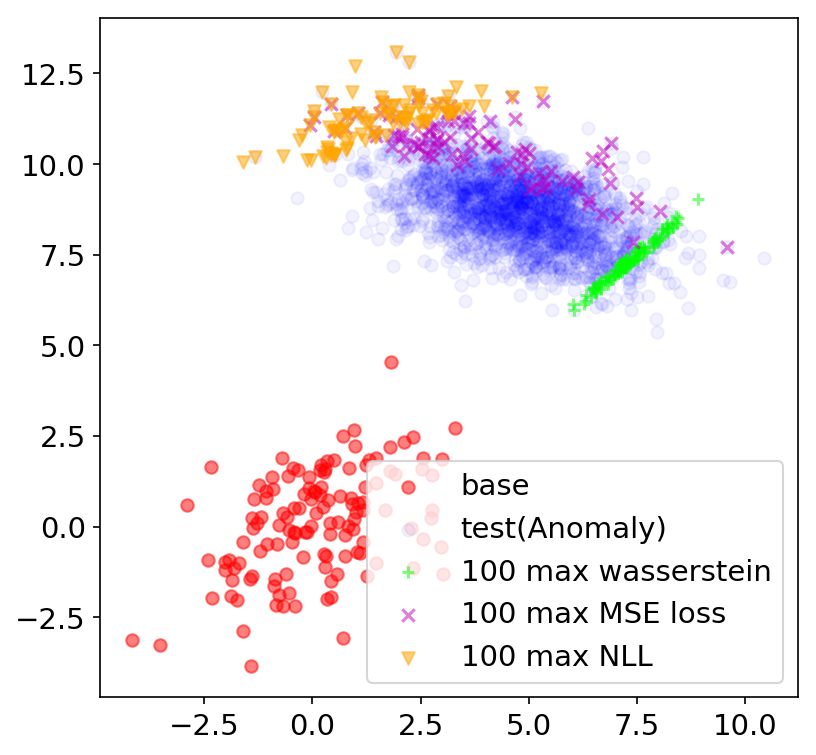

In [36]:
moderate_case.make_scatterplot_with_highlights(100)

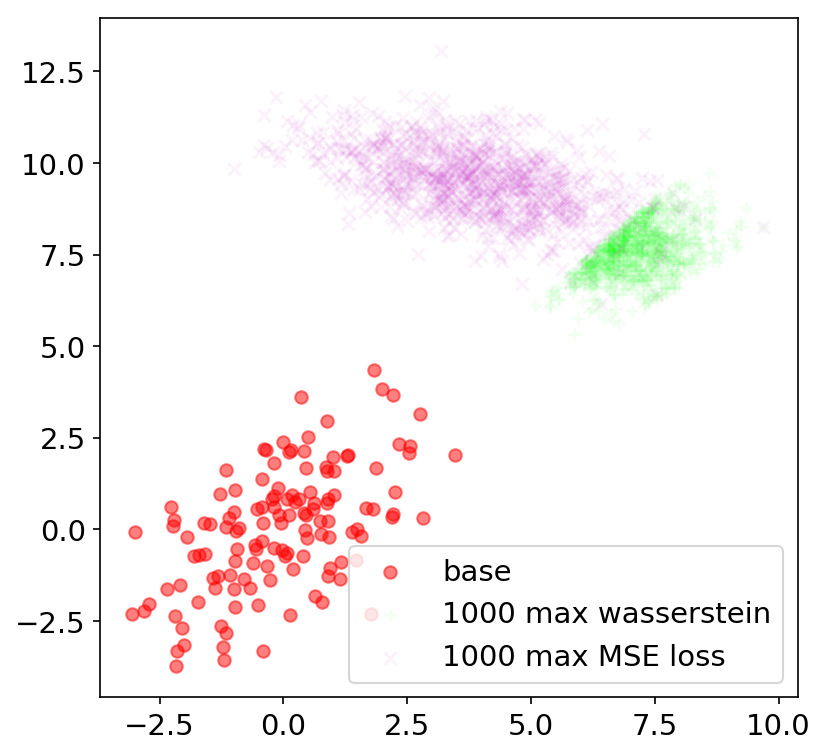

In [55]:
moderate_case.make_scatterplot_with_highlights(1000)

In [47]:
moderate_case.load_model()

In [66]:
(moderate_case.testsample[:,0]**2).shape

torch.Size([10000])

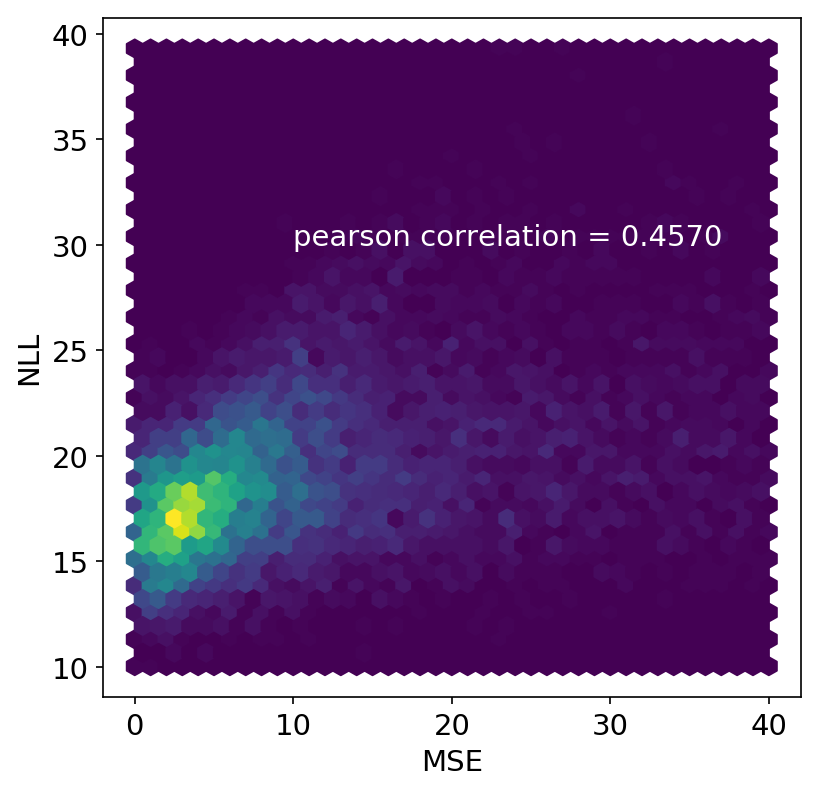

In [50]:
moderate_case.make_hexbinplot_NLL_MSE(40,40,10,30)

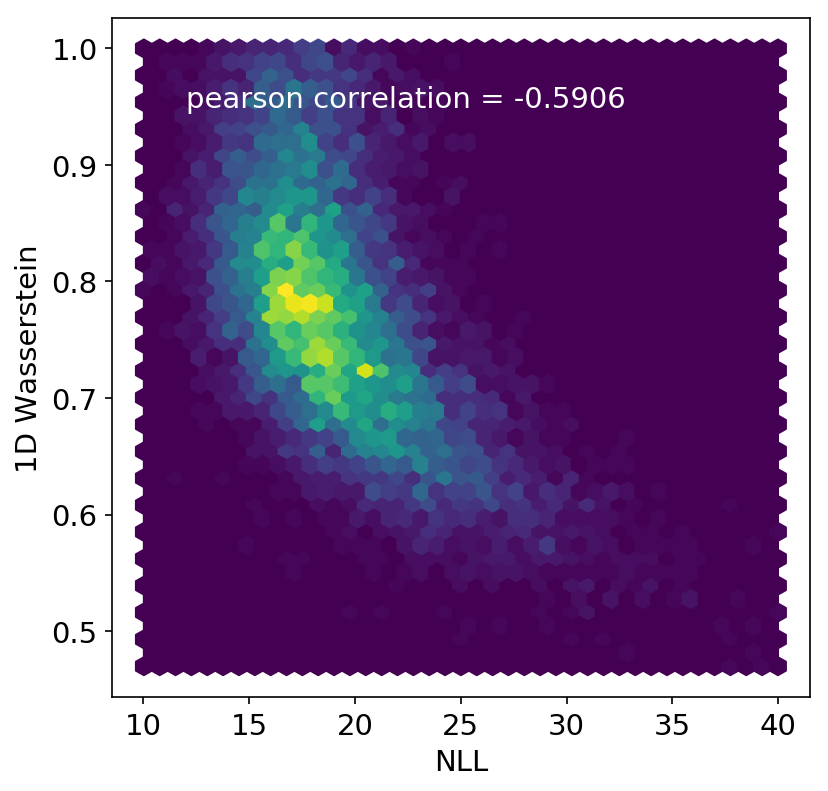

In [53]:
moderate_case.make_hexbinplot_NLL_Wasserstein(40,1,12,.95)

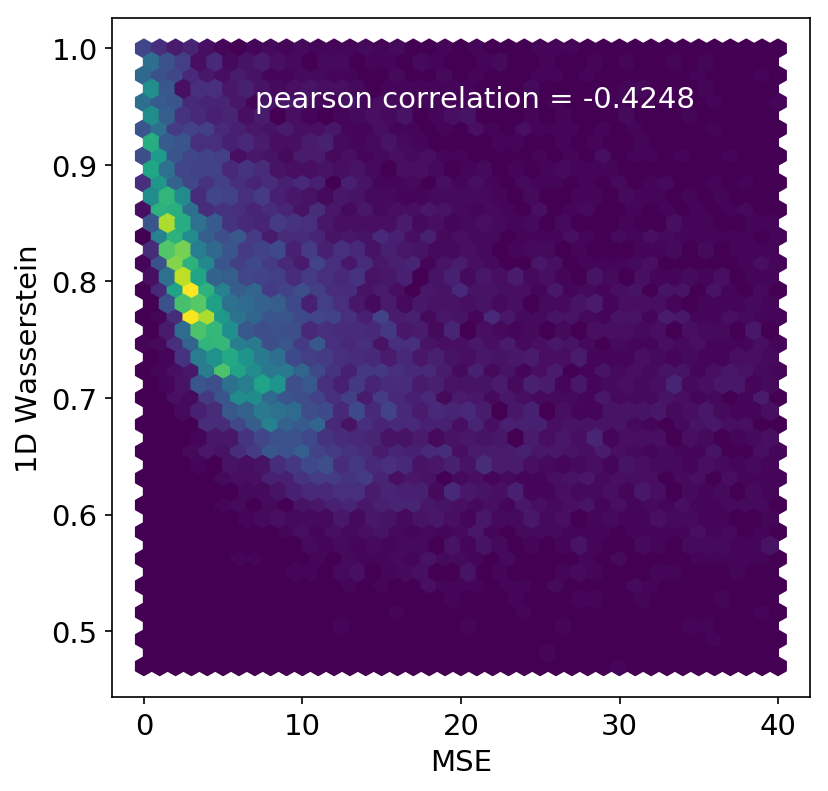

In [55]:
moderate_case.make_hexbinplot_MSE_Wasserstein(40,1,7,.95)

In [54]:
dista_mean = torch.zeros(ndim)
distb_mean = torch.FloatTensor([1.7409, 3.7702])

sigma_a = torch.FloatTensor([[2.2828, 1.3097], [1.3097, 2.5028]])
sigma_b = torch.FloatTensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])
close_case = Case("close_case", dista_mean, distb_mean, sigma_a, sigma_b)
close_case.load_model()

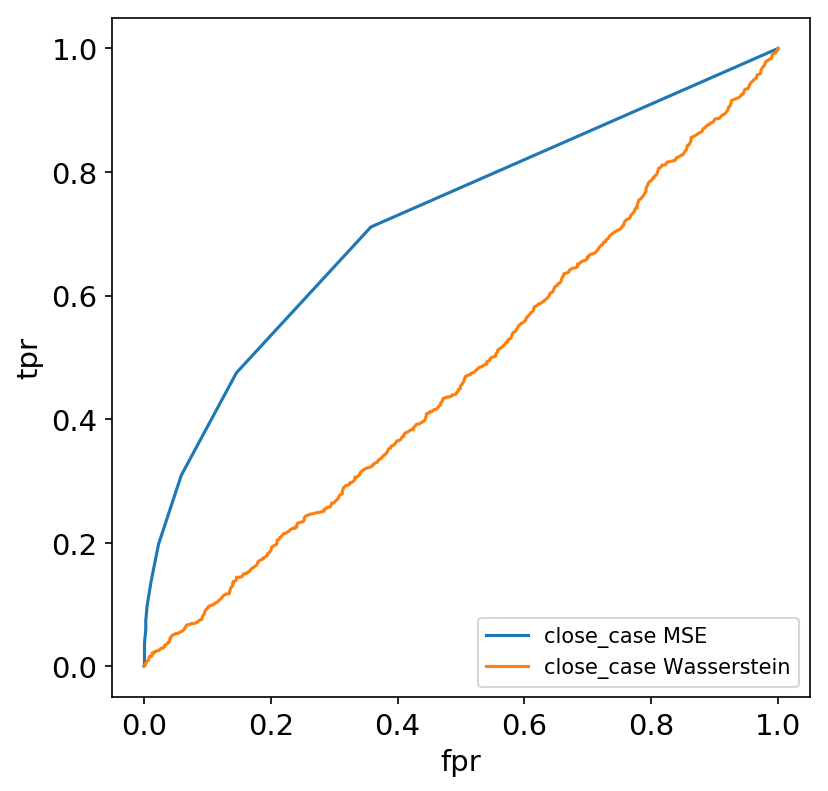

In [79]:
close_case.plot_roc(0,1000,0,1)

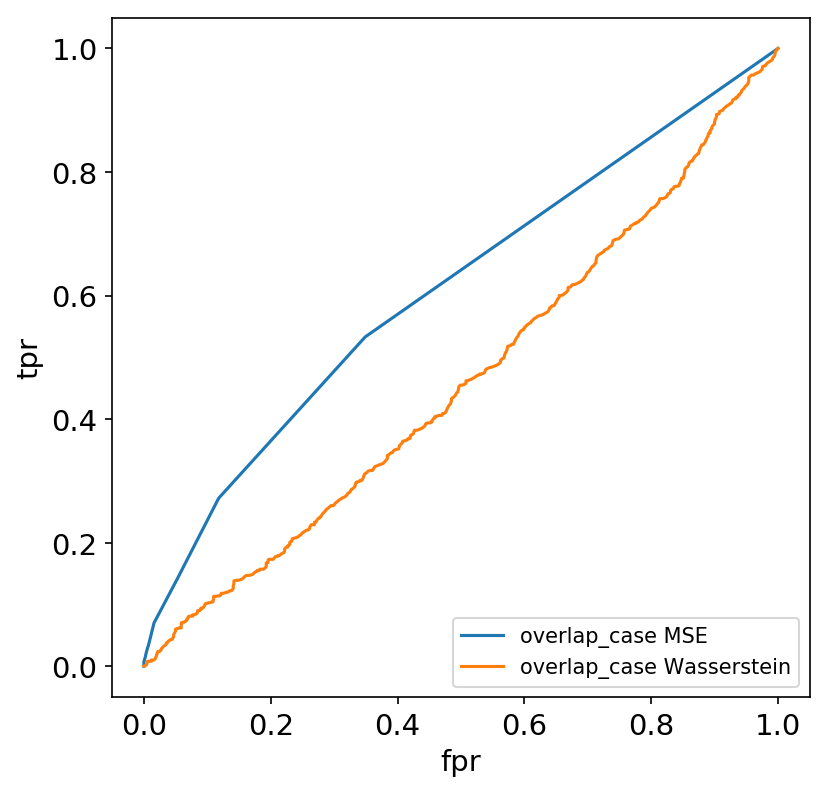

In [78]:
overlap_case.plot_roc(0,1000,0,1)

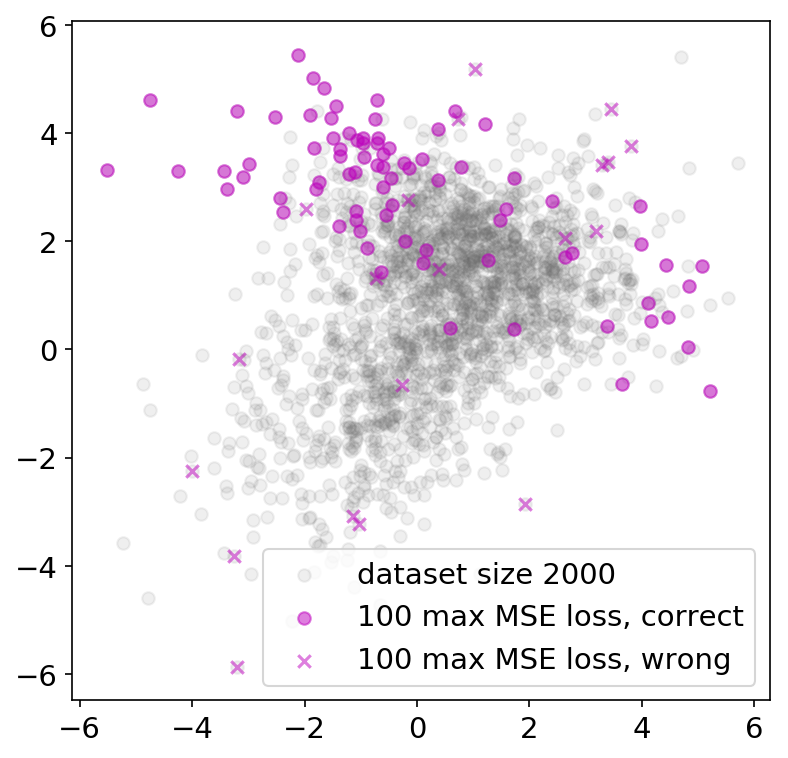

In [55]:
overlap_case.make_scatterplot_anomaly(1000,100, 'Loss')

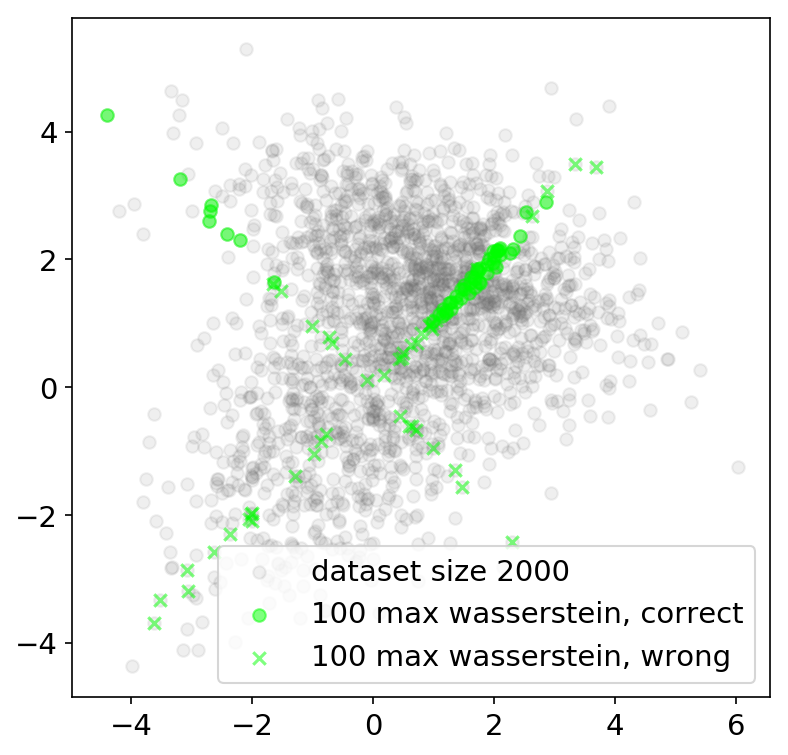

In [56]:
overlap_case.make_scatterplot_anomaly(1000,100, 'Wasserstein')

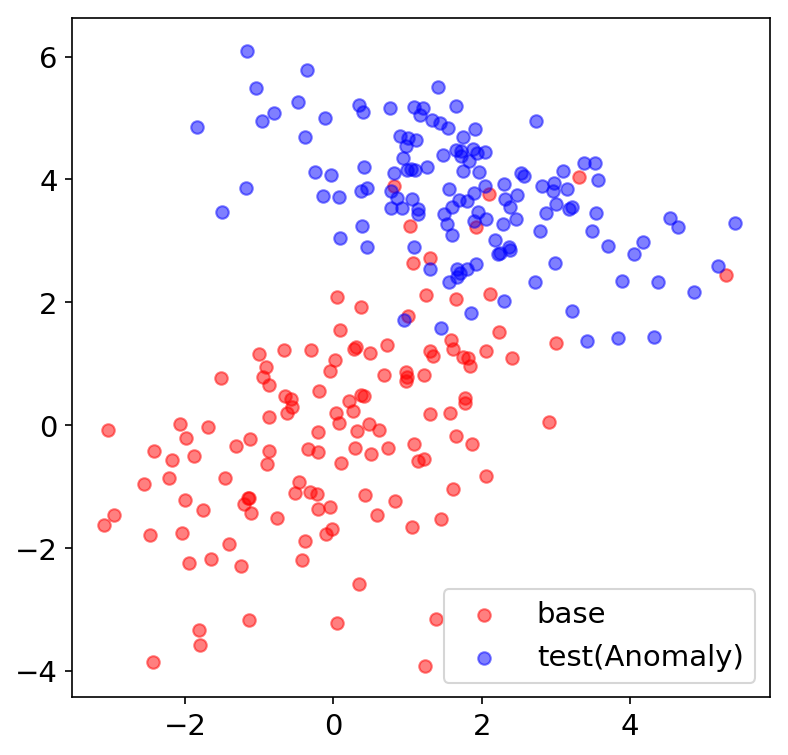

In [37]:
close_case.make_scatterplot()

In [38]:
close_case.load_model()

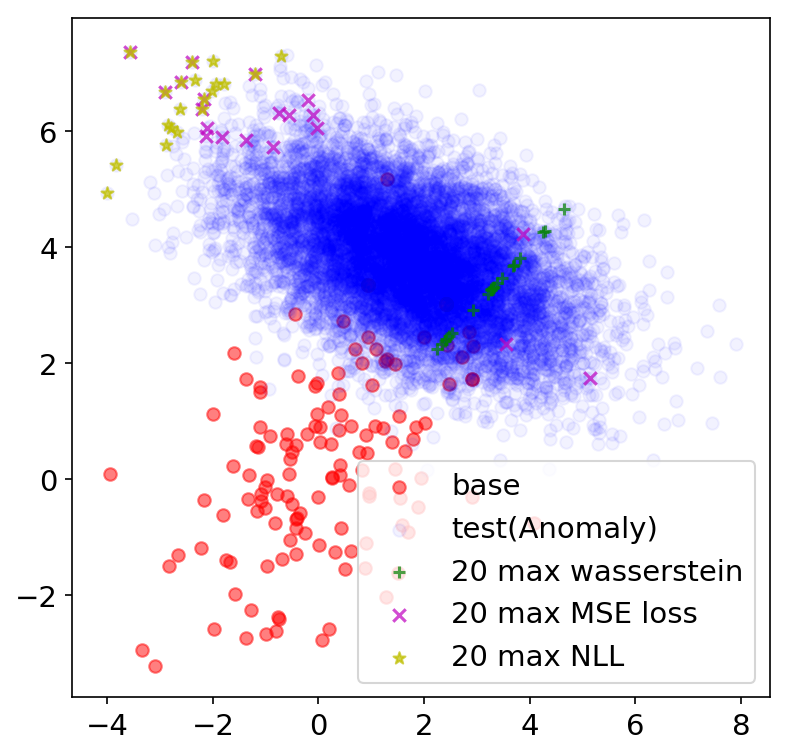

In [39]:
close_case.make_scatterplot_with_highlights()

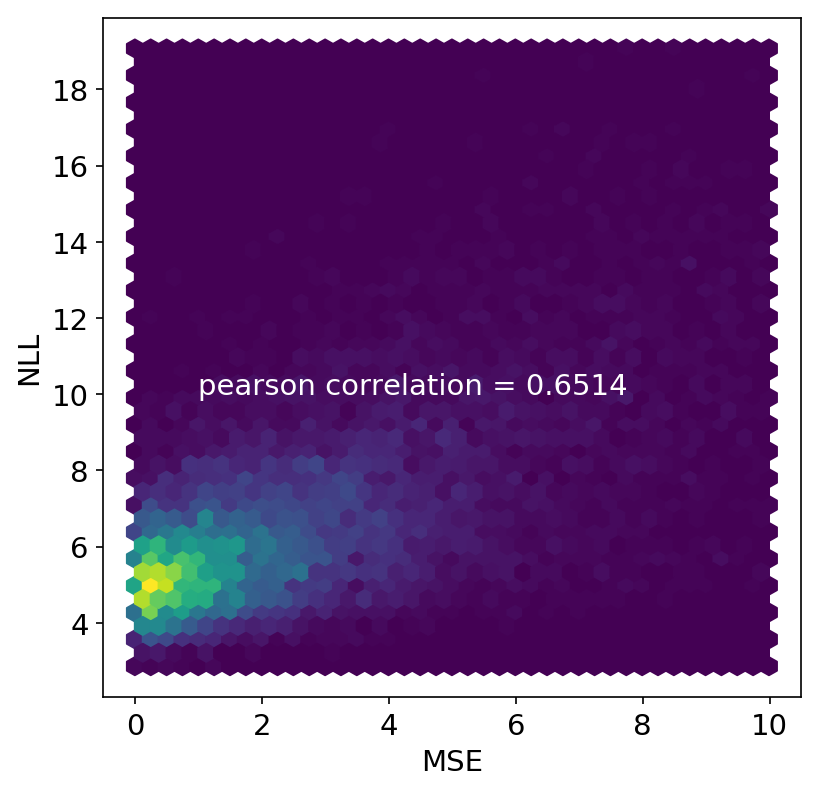

In [61]:
close_case.make_hexbinplot_NLL_MSE(10,20,1,10)

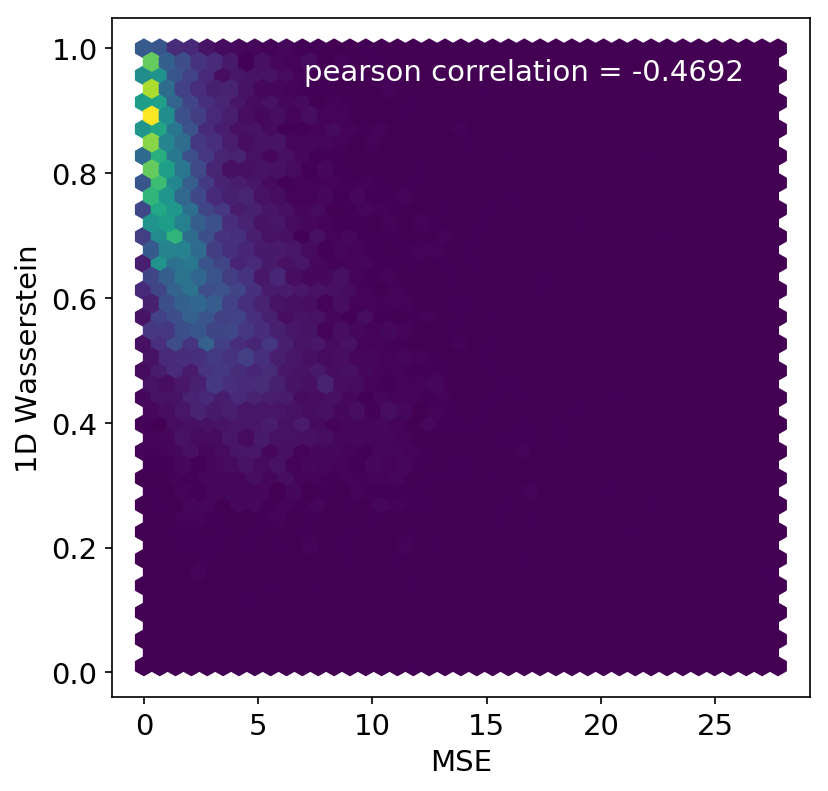

In [63]:
close_case.make_hexbinplot_MSE_Wasserstein(40,1,7,.95)

In [13]:
dista_mean = torch.zeros(ndim)
distb_mean = torch.FloatTensor([1.7409, 3.7702])/2

sigma_a = torch.FloatTensor([[2.2828, 1.3097], [1.3097, 2.5028]])
sigma_b = torch.FloatTensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])
overlap_case = Case("overlap_case", dista_mean, distb_mean, sigma_a, sigma_b)
overlap_case.load_model()

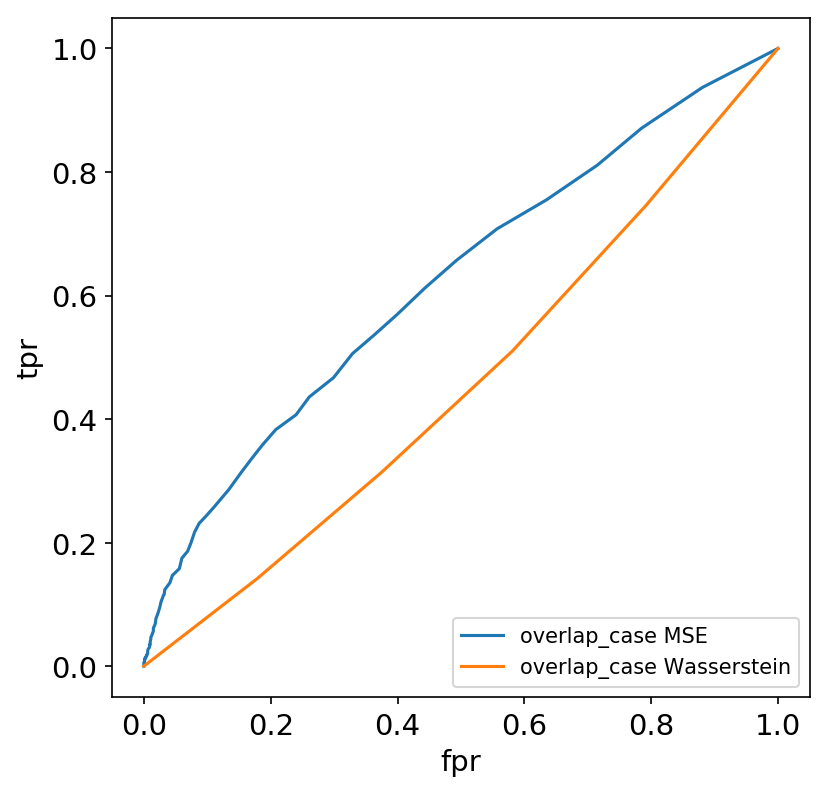

In [52]:
overlap_case.plot_roc(0,100,0,100)

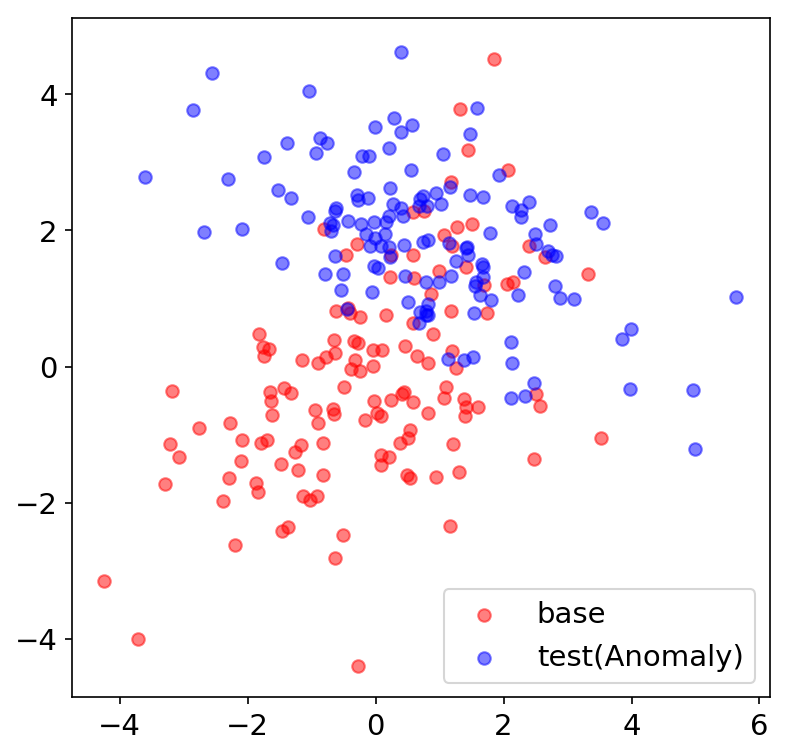

In [46]:
overlap_case.make_scatterplot()

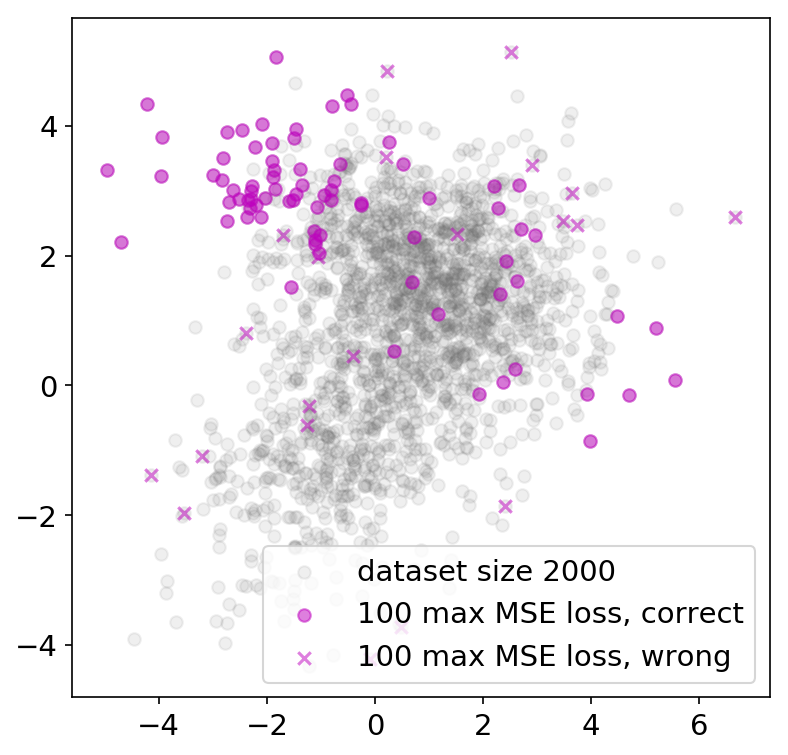

In [42]:
overlap_case.make_scatterplot_anomaly(1000,100, 'Loss')

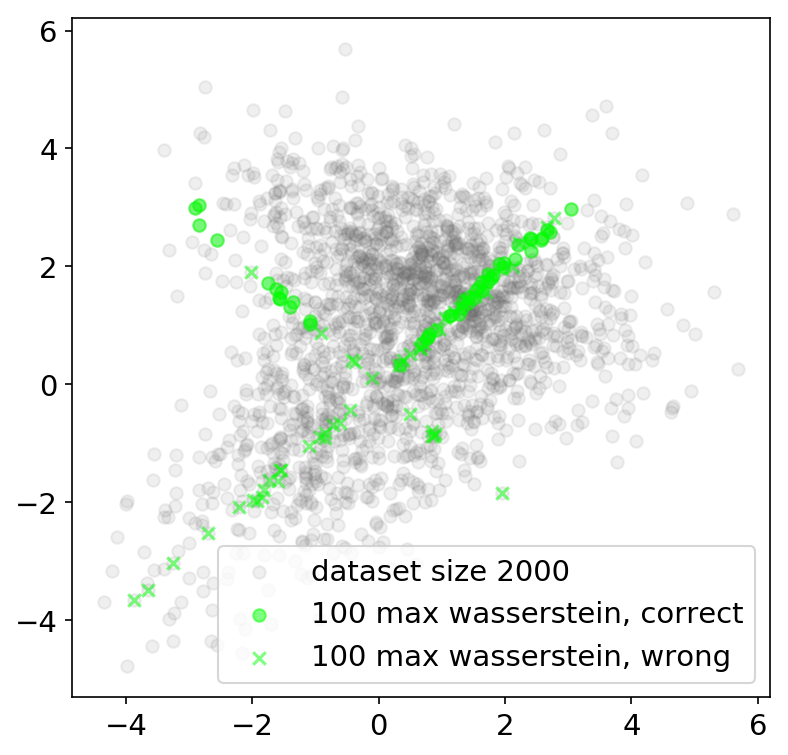

In [43]:
overlap_case.make_scatterplot_anomaly(1000,100, 'Wasserstein')

In [42]:
overlap_case.load_model()

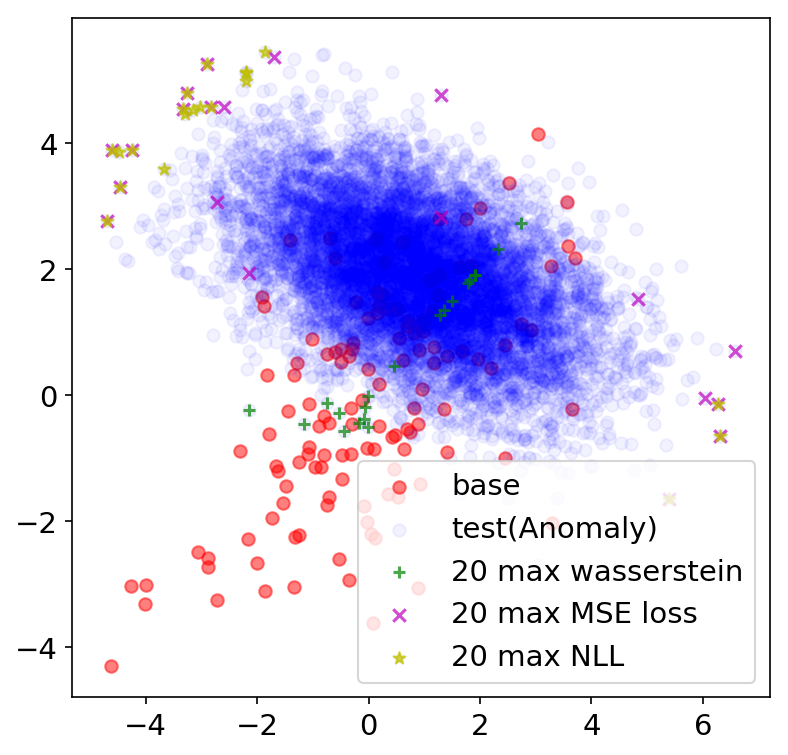

In [43]:
overlap_case.make_scatterplot_with_highlights()

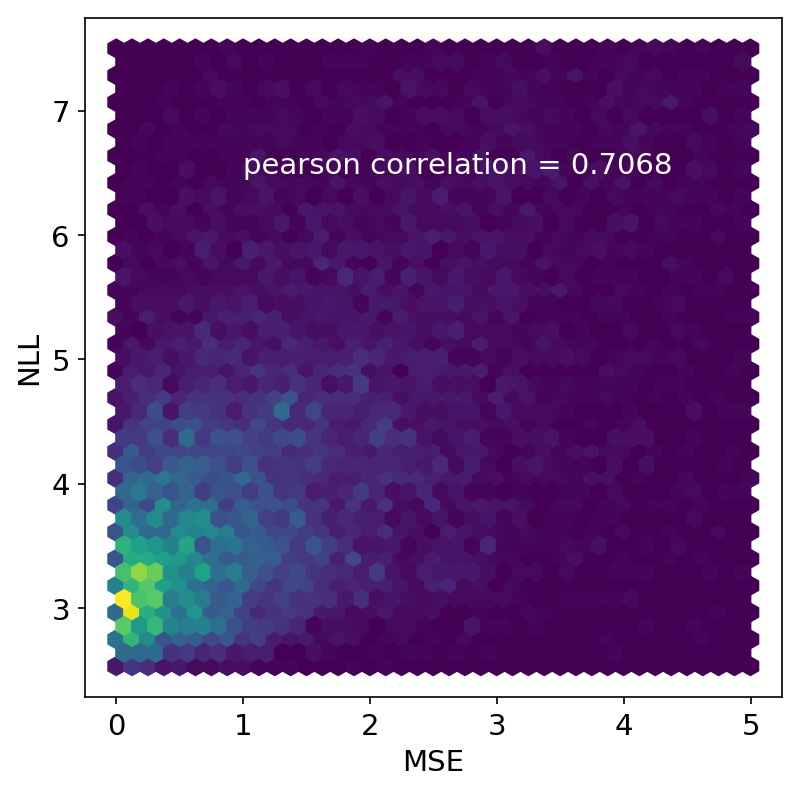

In [32]:
overlap_case.make_hexbinplot_NLL_MSE(5,7.5,1,6.5)

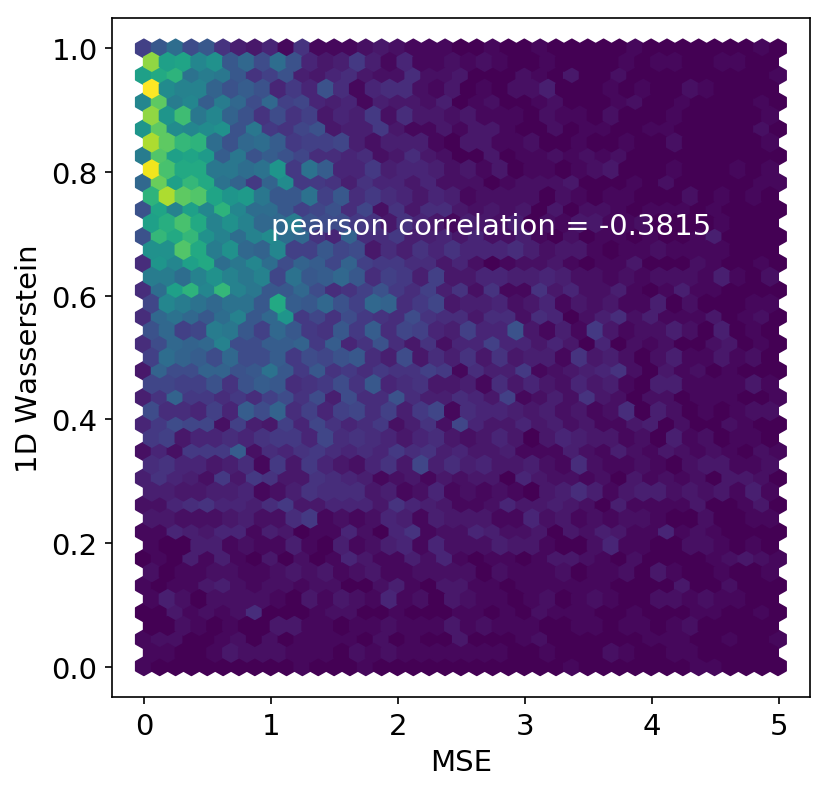

In [36]:
overlap_case.make_hexbinplot_MSE_Wasserstein(5,1,1,.7)

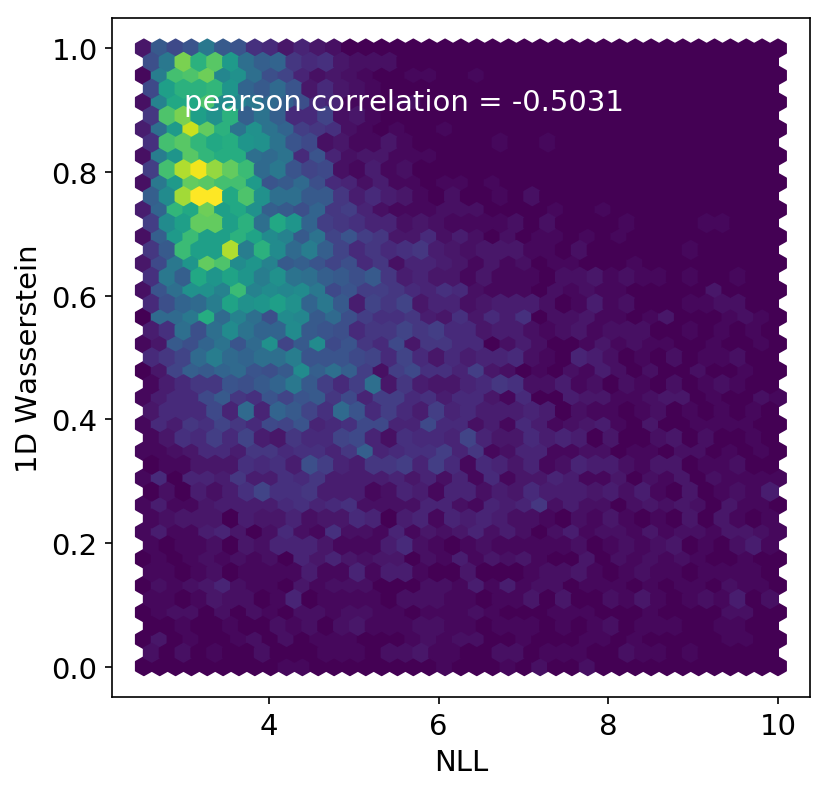

In [39]:
overlap_case.make_hexbinplot_NLL_Wasserstein(10,1,3,.9)

In [ ]:
overlap_case.make_hexbinplot_NLL_MSE(5,7.5,1,6.5)

In [ ]:
dista_mean = torch.zeros(ndim)
distb_mean = torch.FloatTensor([1.7409, 3.7702])/2

sigma_a = torch.FloatTensor([[2.2828, 1.3097], [1.3097, 2.5028]])
sigma_b = torch.FloatTensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])
overlap_case = Case("overlap_case", dista_mean, distb_mean, sigma_a, sigma_b)

In [32]:
random_case = Case("random_case", dista_mean, distb_mean, sigma_a, sigma_b)
random_case.load_model()

In [37]:
random_case.randomly_regenerate()

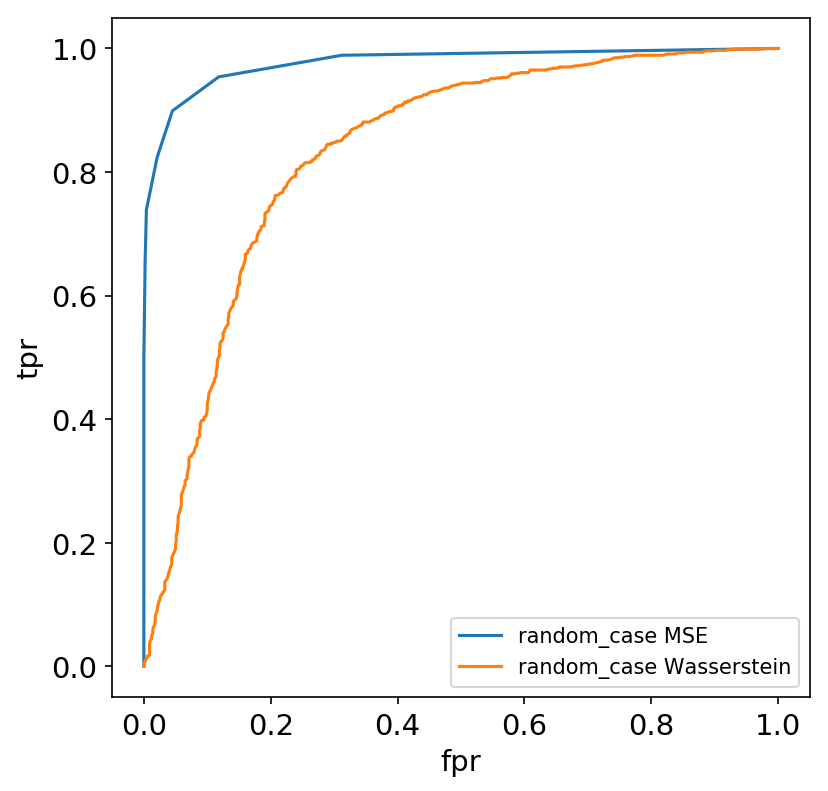

In [38]:
random_case.plot_roc(0,1000,0,1)

In [44]:
random_case.distbase.loc

tensor([0., 0.])

In [45]:
random_case.distbase.covariance_matrix

tensor([[ 2.2243, -0.2456],
        [-0.2456,  0.2810]])

In [46]:
random_case.disttest.loc

tensor([-3.4751,  3.8547])

In [47]:
random_case.disttest.covariance_matrix

tensor([[ 2.2601, -0.2200],
        [-0.2200,  0.2991]])

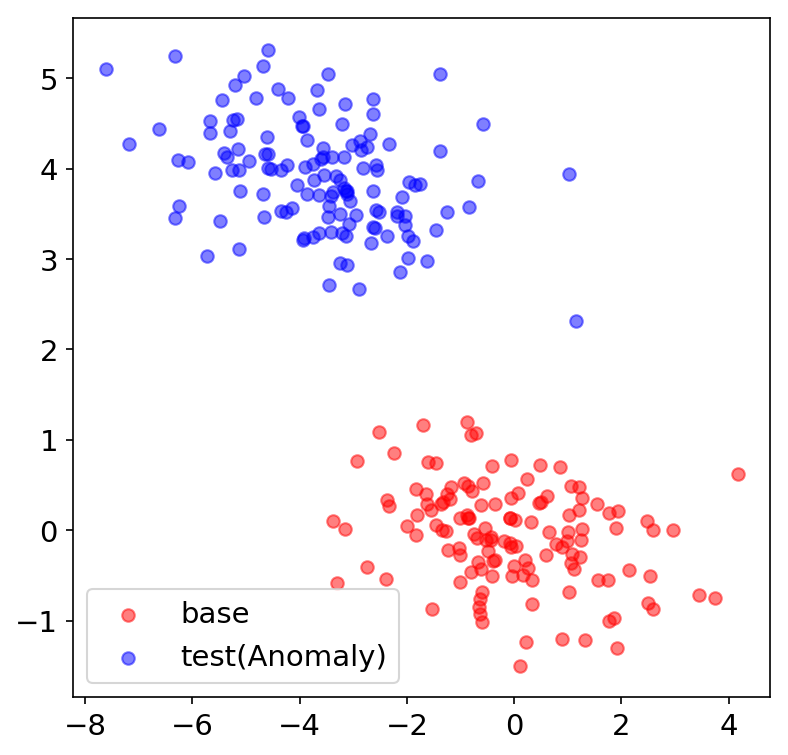

In [51]:
random_case.make_scatterplot()

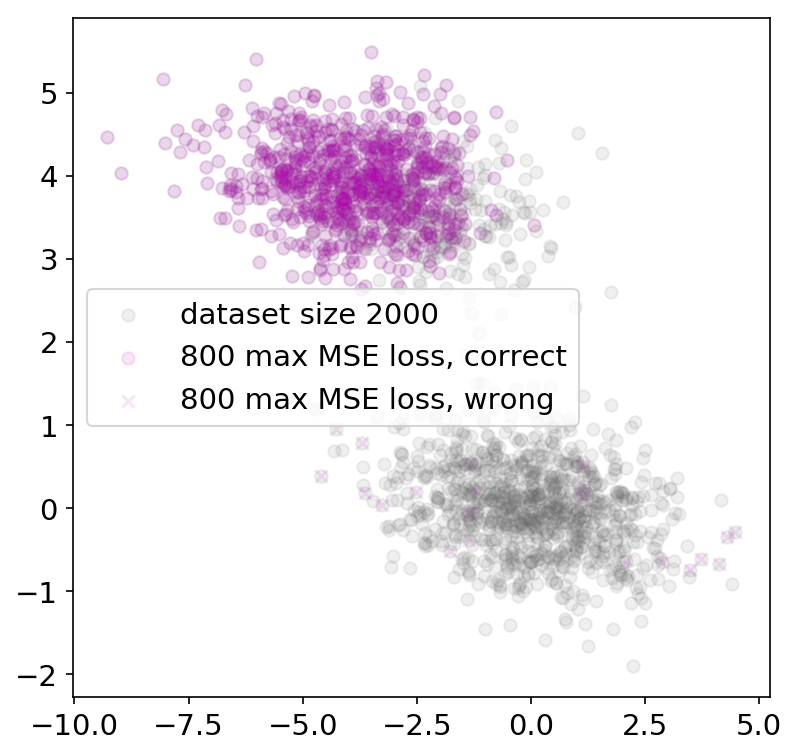

In [53]:
random_case.make_scatterplot_anomaly(1000,800, 'Loss')

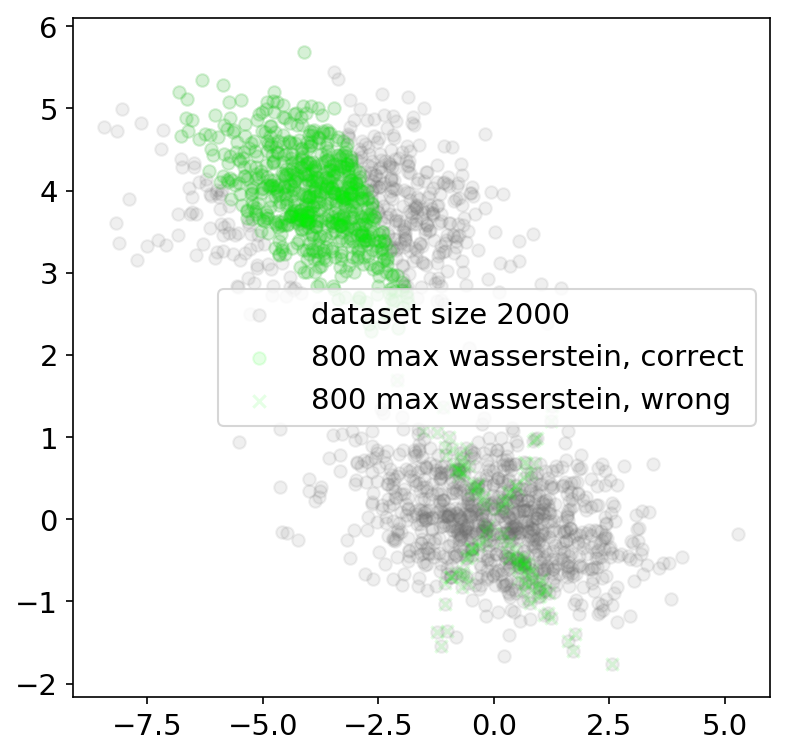

In [54]:
random_case.make_scatterplot_anomaly(1000,800, 'Wasserstein')

In [32]:
moderate_case.train_model()

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1:


KeyboardInterrupt: 

In [45]:
moderate_case.load_model()

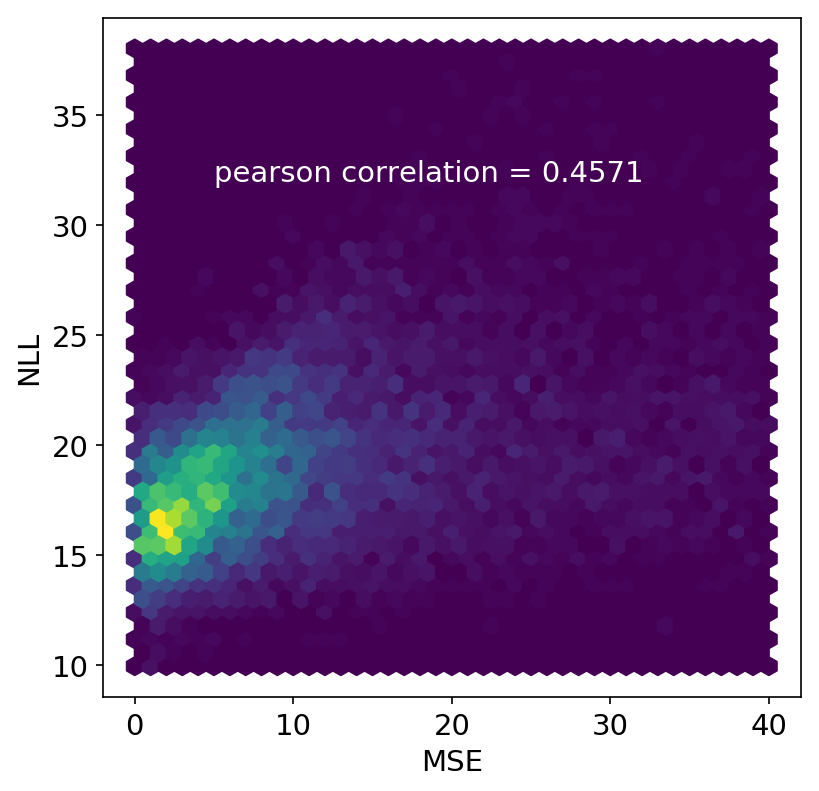

In [46]:
moderate_case.make_hexbinplot_NLL_MSE()

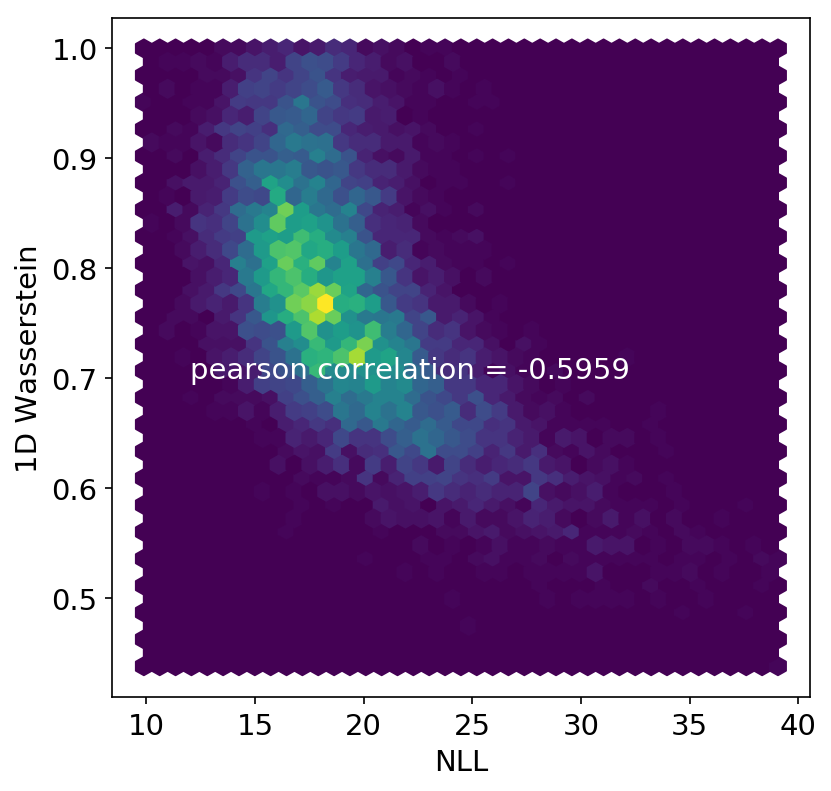

In [56]:
moderate_case.make_hexbinplot_NLL_Wasserstein()

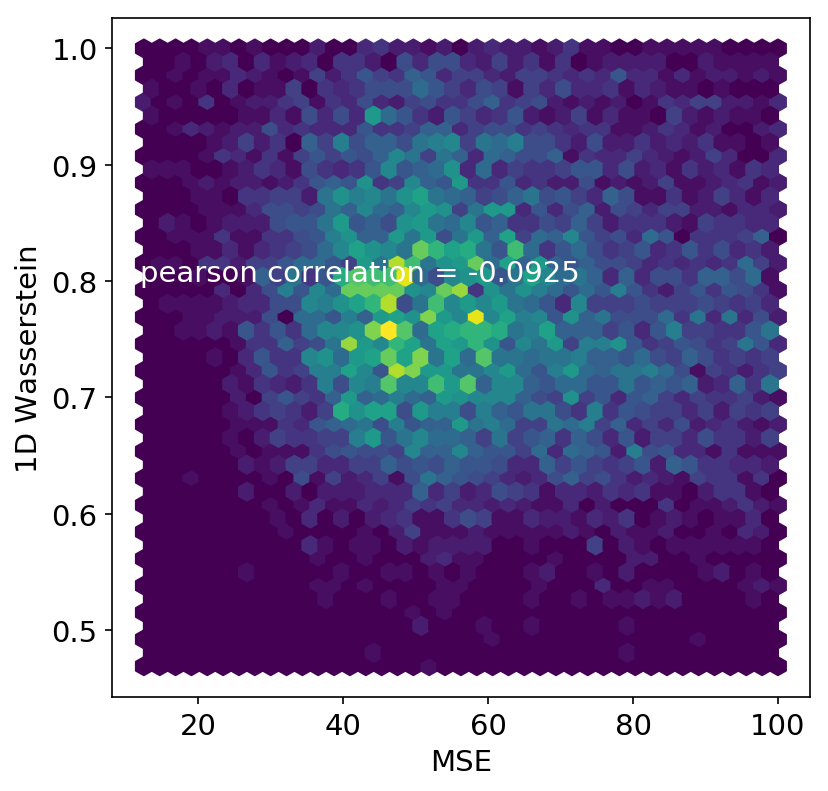

In [64]:
moderate_case.make_hexbinplot_MSE_Wasserstein()

In [ ]:
[4.7409, 8.7702]

In [14]:
dista_mean = torch.zeros(ndim)

In [15]:
dista_mean

tensor([0., 0.])

In [5]:
distb_mean = torch.zeros(ndim).normal_(0., 10.)

In [10]:
distb_mean

tensor([4.7409, 8.7702])

In [31]:
sigma_a = torch.rand(ndim, ndim)

sigma_a = torch.mm(sigma_a, sigma_a.t())

sigma_a.add_(torch.eye(ndim))

tensor([[2.1595, 0.4481],
        [0.4481, 1.1757]])

# sigma_a = torch.tensor([[2.2828, 1.3097], [1.3097, 2.5028]])
# sigma_b = torch.tensor([[ 2.3829, -0.7521],[-0.7521,  0.9825]])

In [188]:
sigma_a

tensor([[2.2828, 1.3097],
        [1.3097, 2.5028]])

In [43]:
sigma_b = torch.rand(ndim, ndim)

sigma_b = torch.mm(sigma_b, sigma_b.t())

sigma_b.add_(torch.eye(ndim))

In [38]:
dista = MultivariateNormal(dista_mean,sigma_a)

distb = MultivariateNormal(distb_mean,sigma_b)

In [47]:
samplea_plot = dista.rsample([100])

sampleb_plot = distb.rsample([100])

plt.scatter(samplea_plot[:,0],samplea_plot[:,1],color='r',alpha= 0.5)
plt.scatter(sampleb_plot[:,0],sampleb_plot[:,1],color='b',alpha= 0.5)

# First Case, Moderate separation, distb_mean = [4.7409, 8.7702]

In [ ]:
class Case:
    def __init__(self, casestring, meanbase, meantarget, sigmabase, sigmatarget):
        self.casestring = casestring
        self.meanbase = meanbase
        self.meantarget = meantarget 
        self.sigmabase = sigmabase
        self.sigmatarget = sigmatarget
        self.distbase = MultivariateNormal(meanbase,sigmabase)
        self.disttarget = MultivariateNormal(meantarget,sigmatarget)
        
    def train_model(self, case, dist_base, dist_test):
    

    def get_NLL(self, case, dist_base, dist_test):

    def get_Loss():

    def get_Wasserstein():

    def get_NLL_Loss_Wasserstein():
    
    def randomly_regenerate(self)

    def make_scatterplot(self):
        samplebase_plot = self.distbase.rsample([130])
        sampletest_plot = self.disttest.rsample([130])
        plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
        plt.scatter(sampletest_plot[:,0],sampletest_plot[:,1],color='b',alpha= 0.5, label='test')
        plt.legend()
        plt.savefig(f'./figures/scatterplot_{case}.png')
        plt.show()
    


In [6]:
moderate_separation = {}

In [ ]:
moderate_separation['case'] = "moderate_separation"

In [50]:
dista_mean = torch.zeros(ndim)

tensor([0., 0.])

In [4]:
distb_mean = torch.tensor([4.7409, 8.7702])

In [147]:
import sklearn.datasets as skdata

In [178]:
sigma_b = skdata.make_spd_matrix(2)

In [179]:
sigma_b = torch.tensor(sigma_b,dtype=torch.float)

In [180]:
#sigma_b = torch.rand(ndim, ndim) 

#sigma_b = torch.mm(sigma_b, sigma_b.t()) 

#sigma_b.add_(torch.eye(ndim))

In [181]:
#sigma_a = torch.tensor([[1.9780, 0.1066],[0.1066, 1.3919]])
#sigma_b = torch.tensor([[1.1162, 0.3408],[0.3408, 2.0634]])

In [187]:
sigma_b

tensor([[ 2.3829, -0.7521],
        [-0.7521,  0.9825]])

In [182]:
dista = MultivariateNormal(dista_mean,sigma_a)
distb = MultivariateNormal(distb_mean,sigma_b)

In [185]:
samplea_plot = dista.rsample([200])
sampleb_plot = distb.rsample([200])



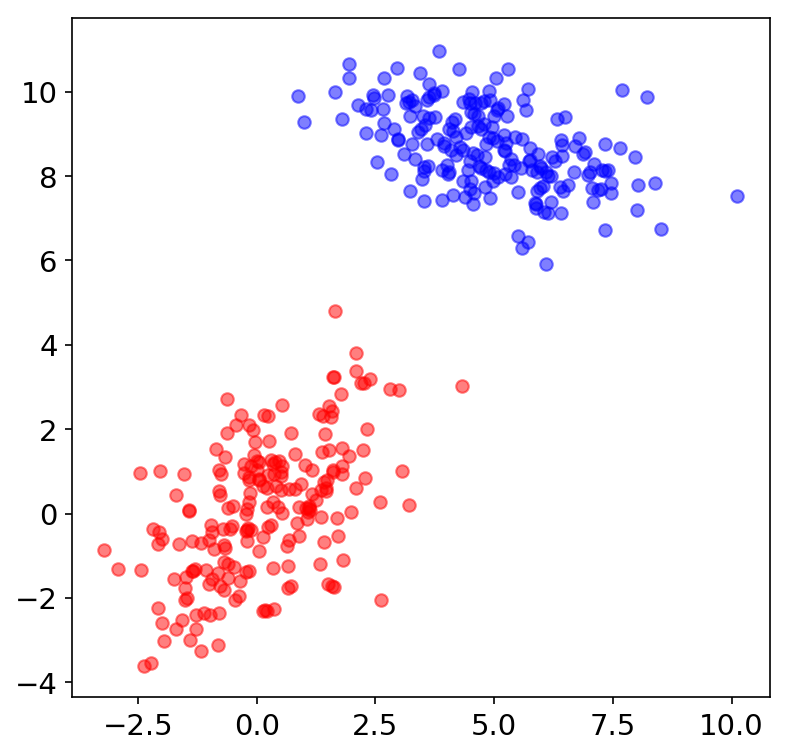

In [186]:
plt.scatter(samplea_plot[:,0],samplea_plot[:,1],color='r',alpha= 0.5)
plt.scatter(sampleb_plot[:,0],sampleb_plot[:,1],color='b',alpha= 0.5)

In [ ]:
def train_model(case, dist_base, dist_test):
    

def get_NLL(case, dist_base, dist_test):

def get_Loss():

def get_Wasserstein():

def get_NLL_Loss_Wasserstein():
    

def make_scatterplot(case, dist_base, dist_test):
    samplebase_plot = dista.rsample([130])
    sampletest_plot = distb.rsample([130])
    plt.scatter(samplebase_plot[:,0],samplebase_plot[:,1],color='r',alpha= 0.5, label='base')
    plt.scatter(sampletest_plot[:,0],sampletest_plot[:,1],color='b',alpha= 0.5, label='test')
    plt.legend()
    plt.savefig(f'./figures/scatterplot_{case}.png')
    plt.show()
    


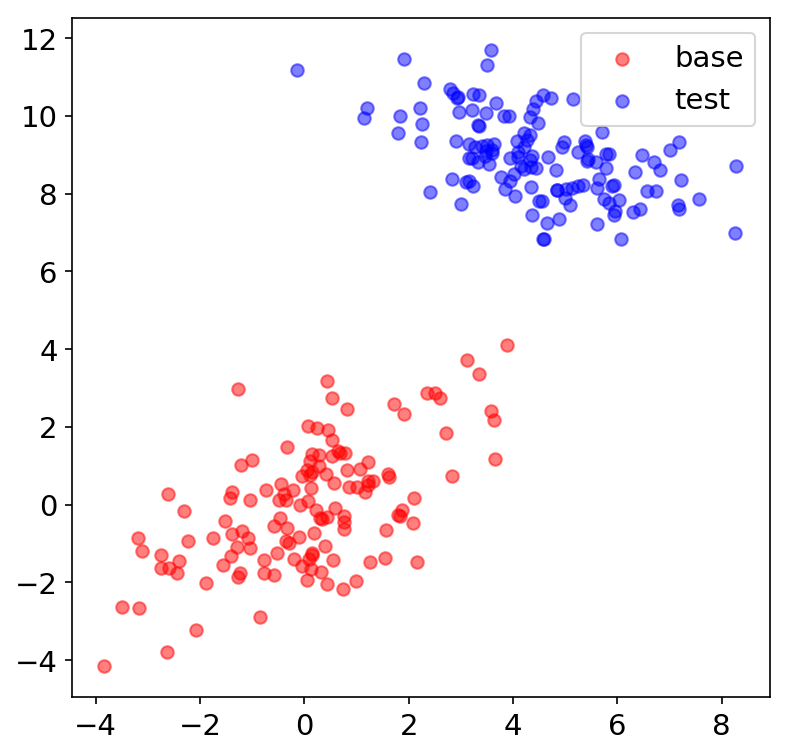

In [190]:
make_scatterplot("moderate_separation",dista,distb)

In [80]:
random_case = Case("random_case", dista_mean, distb_mean, sigma_a, sigma_b)
    

In [17]:
random_case.randomly_regenerate()

In [18]:
random_case.make_scatterplot()

RuntimeError: expected scalar type Float but found Double

In [82]:
import sklearn.datasets as skdata

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [ ]:
sample = distb.rsample([10000])

In [13]:
sample.shape

torch.Size([10000, 100])

In [14]:
NLL = -dista.log_prob(sample)

In [15]:
NLL

tensor([2538.7844, 2165.9854, 2127.8879,  ..., 2315.6997, 2247.3738,
        2263.1704])

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import wasserstein_distance

In [17]:
MSEloss = torch.mean((sample- dista_mean)**2,dim=1)

In [18]:
MSEloss

tensor([124.0900, 136.5656, 127.2197,  ..., 155.9555, 120.6306, 128.4859])

In [19]:
MSEloss.size()

torch.Size([10000])

In [20]:
plotrange = np.where((MSEloss<200) & (NLL<2200))[0]

In [21]:
pearsonr_MSENLL = pearsonr(MSEloss, NLL)


Text(100, 2000, 'pearson correlation = 0.1756')

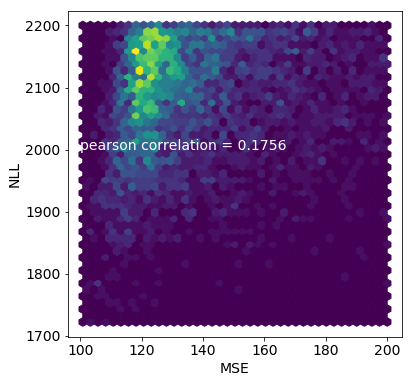

In [22]:
plt.hexbin(MSEloss[plotrange],NLL[plotrange],gridsize=40)
plt.xlabel('MSE')
plt.ylabel('NLL')
plt.text(100,2000,f'pearson correlation = {pearsonr_MSENLL[0]:.4f}',color='white')
#plt.text(1,2.1,f'evaluated on QCD',color='white')

In [23]:
vfunc = np.vectorize(wasserstein_distance,signature='(n),(n)->()')


In [24]:
wasserstein1d = vfunc(sample, dista_mean)

In [25]:
wasserstein1d.shape

(10000,)

In [26]:
pearsonr_MSENLL = pearsonr(MSEloss, NLL)


In [27]:
pearsonr_MSEWAS = pearsonr(MSEloss, wasserstein1d)
pearsonr_NLLWAS = pearsonr(NLL, wasserstein1d)

In [28]:
pearsonr_MSEWAS

(0.9858094209799457, 0.0)

In [29]:
pearsonr_NLLWAS

(0.05666340391868877, 1.4264112310449954e-08)

In [31]:
plotrange1 = np.where((MSEloss<300) & (wasserstein1d<14))[0]

Text(120, 13, 'pearson correlation = 0.9858')

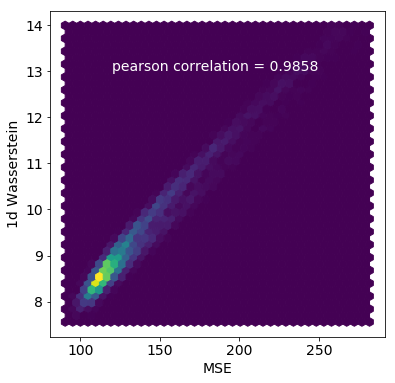

In [33]:
plt.hexbin(MSEloss[plotrange1],wasserstein1d[plotrange1],gridsize=40)
plt.xlabel('MSE')
plt.ylabel('1d Wasserstein')
plt.text(120,13,f'pearson correlation = {pearsonr_MSEWAS[0]:.4f}',color='white')
##plt.text(1,2.1,f'evaluated on QCD',color='white')

In [35]:
plotrange2 = np.where((MSEloss<300) & (wasserstein1d<14))[0]

Text(1400, 13, 'pearson correlation = 0.0567')

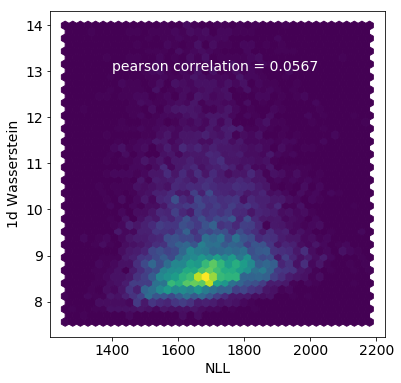

In [38]:
plt.hexbin(NLL[plotrange2],wasserstein1d[plotrange2],gridsize=40)
plt.xlabel('NLL')
plt.ylabel('1d Wasserstein')
plt.text(1400,13,f'pearson correlation = {pearsonr_NLLWAS[0]:.4f}',color='white')
##plt.text(1,2.1,f'evaluated on QCD',color='white')

In [39]:
import time
import tqdm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data as utils
import torch.nn.init as init
from torch.autograd import Variable
import sys
sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

In [40]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from models import NormalizingFlowModel

In [41]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(100, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 100)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [42]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

#N_FLOWS = 6 
#Z_DIM = 8

N_FLOWS = 10
Z_DIM = 8

n_steps = 0

In [47]:
train_data = dista.rsample([100000])

In [48]:
total_PureBkg_selection = torch.tensor(train_data)

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [49]:
bs = 800
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

In [50]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [58]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [53]:
beta = 1

In [54]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        x = x.float().cuda()
        x_tilde, kl_div = model(x)

        mseloss = nn.MSELoss(size_average=False) 
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1


In [55]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [56]:
ae_def = {
    "type":"Distance_studies",
    "trainon":"Gaussian",
    "features":"RandomSample",
    "architecture":"MAF",
    "selection":"noselection",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z8f8",
}


In [61]:
N_EPOCHS = 10
BEST_LOSS = 99999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break

Epoch 1:

Evaluation Completed (valid)!	Loss: 760.4197 Time: 2.610 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: 760.4091 Time: 2.702 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: 760.4317 Time: 2.599 s
Not saving model! Last saved: 2
Epoch 4:

Evaluation Completed (valid)!	Loss: 760.4300 Time: 2.360 s
Not saving model! Last saved: 2
Epoch 5:


KeyboardInterrupt: 

In [63]:


model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))



<All keys matched successfully>

In [64]:
sample.shape

torch.Size([10000, 100])

In [ ]:
MSEloss_VAE = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()